# GrooveGen: Input-Conditioned Drum Loop Generator
### ___Avinash Duggal, Ethan Kusnadi___

---

This notebook demonstrates GrooveGen, a generative model designed to create realistic, stylistically controlled drum grooves based on user-defined inputs like genre and tempo. All code for the data pipeline, model architecture, and evaluation is included in the cells below.

### **Setup, Library Imports, and Dataset Loading**

In [ ]:
from google.colab import drive
import getpass
import os

drive.mount('/content/drive')

TFDS_DIR = "/content/drive/Shareddrives/groove_gen/tfds_cache"

USER = getpass.getuser()
RUN_ID = f"{USER}_run2"
OUTPUT_DIR = f"/content/drive/Shareddrives/groove_gen/{RUN_ID}"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Saving outputs to:", OUTPUT_DIR)

Mounted at /content/drive
Saving outputs to: /content/drive/Shareddrives/groove_gen/root_run2


In [ ]:
%pip install pretty_midi
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pretty_midi as pm
import io
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

!apt-get update -qq && apt-get install -y timidity
from IPython.display import Audio

tf.random.set_seed(100)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=a022c9747229cba45dfd5821a66ffe209cddf95f7c8bc8162bc17cbb23f5981b
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty_midi
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libao-common libao4
Suggested packages:
  fluid-soundfont-gs libaudio2 libsndio6.1 freepats pmidi timidity-daemon
The following NEW packages 

### **Loading the Groove MIDI Dataset**

Loads the Groove MIDI Dataset (4-bar, MIDI-only version) from the TensorFlow Datasets library, using the cached copy stored in Google Drive to avoid re-downloading. It then builds an efficient TensorFlow data pipeline by filtering for 4/4 time, shuffling the samples, batching them into groups of 32, and prefetching batches asynchronously for faster training and iteration.

In [ ]:
dataset = tfds.load(
    name="groove/4bar-midionly",
    split=tfds.Split.TRAIN,
    try_gcs=True,
    data_dir=TFDS_DIR,
    read_config=tfds.ReadConfig(try_autocache=True)
)

# Filter for only 4/4 time signatures
dataset = dataset.filter(lambda x: x["time_signature"] == 1)
dataset = dataset.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
print("Successfully batched")

Successfully batched


### **MIDI Object Inspection**

 Take a single batch of data and extract MIDI bytes, genre, BPM, and time signature. The core part of this cell converts MIDI bytes into a `pretty_midi.PrettyMIDI` object and prints information about the instruments and the first few notes within that MIDI object.

In [ ]:
# Take one batch
for features in dataset.take(1):
    midi = features["midi"]
    genre = features["style"]["primary"]
    bpm = features["bpm"]

# Convert MIDI bytes to PrettyMIDI object
midi_bytes = midi.numpy()[0]
pm_obj = pm.PrettyMIDI(io.BytesIO(midi_bytes))

drum_instruments = [inst for inst in pm_obj.instruments if inst.is_drum]

# Inspect notes and instruments
for instrument in drum_instruments:
    for note in instrument.notes[:10]:  # show first 10 notes
        print(f"Pitch: {note.pitch}, Start: {note.start:.2f}, End: {note.end:.2f}, Velocity: {note.velocity}")


Pitch: 38, Start: 0.12, End: 0.23, Velocity: 62
Pitch: 42, Start: 0.27, End: 0.37, Velocity: 62
Pitch: 36, Start: 0.28, End: 0.38, Velocity: 62
Pitch: 26, Start: 0.40, End: 0.51, Velocity: 68
Pitch: 44, Start: 0.45, End: 0.55, Velocity: 35
Pitch: 38, Start: 0.56, End: 0.66, Velocity: 93
Pitch: 36, Start: 0.69, End: 0.79, Velocity: 61
Pitch: 22, Start: 0.69, End: 0.79, Velocity: 102
Pitch: 38, Start: 0.82, End: 0.92, Velocity: 45
Pitch: 22, Start: 0.98, End: 1.08, Velocity: 127


### **Drum Class and Pitch Mapping**

This cell creates `PITCH_TO_CLASS`, a dictionary that maps raw MIDI drum pitches to their corresponding canonical drum class indices. This mapping is crucial for normalizing various drum sounds into a consistent set of categories.

In [ ]:
# 9 canonical drum classes
DRUM_CLASSES = {
    0: "kick",
    1: "snare",
    2: "hh_closed",
    3: "hh_open",
    4: "tom_low",
    5: "tom_mid",
    6: "tom_floor",
    7: "ride",
    8: "crash"
}

# Map raw MIDI pitches -> class index
# (Roland/GM variants merged into 9 classes; based on the GMD paper’s reduced mapping)
PITCH_TO_CLASS = {
    # Kick
    36: 0,
    # Snare (head/rim/x-stick -> snare)
    38: 1, 40: 1, 37: 1,
    # Closed Hi-hat (bow/edge/pedal)
    42: 2, 22: 2, 44: 2,
    # Open Hi-hat
    46: 3, 26: 3,
    # Low/Mid/High toms (merge rims to same)
    45: 4,
    47: 5, 48: 5, 50: 5,
    43: 6, 58: 6,
    # Ride (bow/edge/bell)
    51: 7, 59: 7, 53: 7,
    # Crash (1/2 variants, splash, china mapped to crash)
    49: 8, 57: 8, 55: 8, 52: 8
}


### **`midi_to_hov` Function Definition**

This cell defines the `midi_to_hov` function, which converts a `PrettyMIDI` drum performance into three matrices: Hit (`H`), Offset (`O`), and Velocity (`V`). These matrices represent drum events at a 16th-note resolution.

- `H`: A binary matrix indicating if a drum hit occurred at a specific time step and for a specific drum class.
- `O`: A matrix storing the fractional offset (timing deviation) from the exact 16th-note grid for each hit.
- `V`: A matrix storing the normalized velocity (loudness) for each hit.

The function accounts for BPM and quantizes notes to the nearest 16th-note step, clipping offsets to a `[-0.5, 0.5)` range and handling note collisions by keeping the loudest note.

In [ ]:
def midi_to_hov(pm_obj: pm.PrettyMIDI, bpm: float, steps_per_quarter: int = 4):
    """
    Convert a PrettyMIDI drum performance to H, O, V matrices at 16th-note resolution.
    Returns H, O, V with shape (T, M) where T = 4 * 16 and M = 9.
    """
    assert bpm > 0, "BPM must be positive"
    T = 64  # 16 sixteenth-notes per bar in 4/4
    M = 9   # 9 drum classes

    H = np.zeros((T, M), dtype=np.float32)
    O = np.zeros((T, M), dtype=np.float32)
    V = np.zeros((T, M), dtype=np.float32)

    # duration of one 16th in seconds
    sec_per_quarter = 60.0 / float(bpm)
    sec_per_16th = sec_per_quarter / steps_per_quarter

    drums = [inst for inst in pm_obj.instruments if inst.is_drum]

    for inst in drums:
        for note in inst.notes:
            pitch = note.pitch
            if pitch not in PITCH_TO_CLASS:
                continue
            cls = PITCH_TO_CLASS[pitch]

            # Compute nearest 16th index
            t_float = note.start / sec_per_16th
            t_idx = int(np.round(t_float))

            # Outside of our 4-bar window
            if t_idx < 0 or t_idx >= T:
                continue

            # Fractional offset relative to chosen grid step, normalized to [-0.5, 0.5)
            offset = (note.start - t_idx * sec_per_16th) / sec_per_16th
            # Clip to the paper's range (safety)
            offset = float(np.clip(offset, -0.5, 0.5 - 1e-6))

            vel = note.velocity / 127.0

            # Keep the loudest note if collision
            if vel > V[t_idx, cls]:
                H[t_idx, cls] = 1.0
                V[t_idx, cls] = vel
                O[t_idx, cls] = offset

    return H, O, V


### **Data Preprocessing Functions and TensorFlow Dataset Creation**

This cell defines several functions to process batches of data and integrate them into a `tf.data.Dataset` for training:

- `one_hot`: A helper function to create a one-hot encoded vector.
- `process_batch`: Takes a batch of features from the raw dataset, converts MIDI bytes to H.O.V matrices using `midi_to_hov`, and constructs a conditioning vector (`cond`) by combining a one-hot encoding of the primary style and a normalized BPM.
- `dataset_to_training_batches`: A generator function that iterates through the raw dataset, processes each batch using `process_batch`, and yields the `(X, cond)` pairs suitable for a TensorFlow dataset.

Finally, it creates `train_ds` using `tf.data.Dataset.from_generator`, specifying the output signature (shapes and dtypes) for `X` (H.O.V stack) and `cond` (conditioning vector). It also includes optional caching and prefetching for performance.

In [ ]:
def one_hot(index: int, num_classes: int):
    arr = np.zeros((num_classes,), dtype=np.float32)
    arr[index] = 1.0
    return arr

# 18 different style classes
NUM_STYLES = 18

def process_batch(features):
    midi_bytes_batch = features["midi"].numpy()
    bpm_batch = features["bpm"].numpy().astype(np.float32)
    style_primary = features["style"]["primary"].numpy()

    X_list = []
    cond_list = []

    for midi_bytes, bpm, style_idx in zip(midi_bytes_batch, bpm_batch, style_primary):
        pm_obj = pm.PrettyMIDI(io.BytesIO(midi_bytes))
        H, O, V = midi_to_hov(pm_obj, bpm=float(bpm), steps_per_quarter=4)
        # Stack as channels: (T, M, 3)
        X = np.stack([H, O, V], axis=-1).astype(np.float32)

        # Conditioning vector example: [one-hot style (18), normalized bpm]
        bpm_norm = np.clip(bpm / 300.0, 0.0, 1.0)  # crude scaling; tweak as desired
        cond = np.concatenate([one_hot(int(style_idx), NUM_STYLES), np.array([bpm_norm], dtype=np.float32)], axis=0)

        X_list.append(X)
        cond_list.append(cond)

    X_batch = np.stack(X_list, axis=0)       # (B, T, M, 3)
    cond_batch = np.stack(cond_list, axis=0) # (B, 19) -> 18 styles + 1 bpm

    return X_batch, cond_batch

# Build a generator that yields (X, cond) pairs for tf.data
def dataset_to_training_batches(ds):
    for features in ds:
        X, cond = process_batch(features)
        yield X, cond

# Shapes: X -> (B, 64, 9, 3), cond -> (B, 19)
output_signature = (
    tf.TensorSpec(shape=(None, 64, 9, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None, NUM_STYLES + 1), dtype=tf.float32)
)

train_gen = lambda: dataset_to_training_batches(dataset)
train_ds = tf.data.Dataset.from_generator(train_gen, output_signature=output_signature)
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)

cvae_train_ds = train_ds.map(
    lambda x, c: ((x, c), x),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

### **Data Verification and Visualization**

Takes one batch from the processed dataset 'train_ds', then performs several critical checks and assertions to ensure the data is correctly structured and within expected ranges:

- Splits `X_batch` into `Hb` (hits), `Ob` (offsets), and `Vb` (velocities) for individual inspection.
- Asserts correct tensor shapes for `H`, `O`, and `V`.
- Verifies that hit values in `H` are binary (0 or 1).
- Checks that offset values in `O` are within `[-0.5, 0.5)`.
- Confirms that velocity values in `V` are within `[0, 1]`.

It also provides a summary for the first sequence in the batch, including total hits, hits per instrument, and statistics for offsets and velocities where hits occur. Finally, it uses `matplotlib` to visualize the hit patterns (`H`) and masked velocities (`V * H`) as heatmaps, providing a visual inspection of the processed drum patterns.

Total hits: 70
      kick: 12
     snare: 11
 hh_closed: 14
   hh_open: 0
   tom_low: 2
   tom_mid: 3
 tom_floor: 25
      ride: 0
     crash: 3


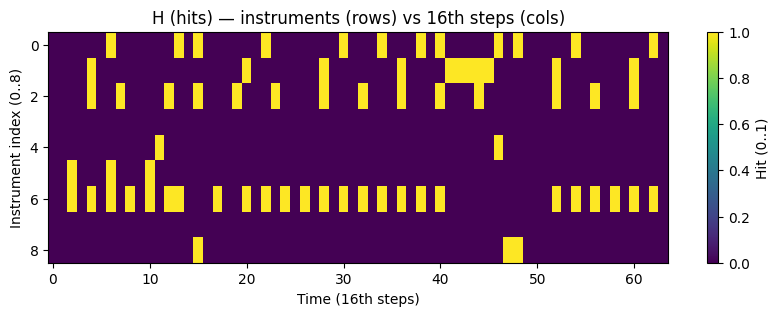

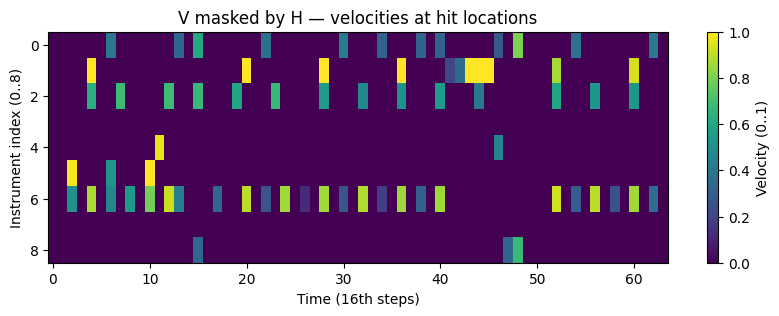

In [ ]:
# Take one batch from the processed dataset train_ds
(X_batch, cond_batch) = next(iter(train_ds))
X_batch = X_batch.numpy()
cond_batch = cond_batch.numpy()

# Split channels
Hb = X_batch[..., 0]  # hits
Ob = X_batch[..., 1]  # offsets
Vb = X_batch[..., 2]  # velocities

assert Hb.shape == Ob.shape == Vb.shape == (X_batch.shape[0], 64, 9), "Unexpected tensor shapes"
assert np.all((Hb == 0.0) | (Hb == 1.0)), "H contains non-binary values"
assert Ob.min() >= -0.5 - 1e-6 and Ob.max() < 0.5 + 1e-6, "Offsets out of range"
assert Vb.min() >= -1e-6 and Vb.max() <= 1.0 + 1e-6, "Velocities out of range"

# Take first sequence in batch
b = 0
H = Hb[b]
O = Ob[b]
V = Vb[b]

print("Total hits:", int(H.sum()))
hits_per_instr = H.sum(axis=0).astype(int)
for i, count in enumerate(hits_per_instr):
    name = DRUM_CLASSES[i]
    print(f"{name:>10s}: {count}")

# Plot hit and velocity heatmaps for this sequence
plt.figure(figsize=(10, 3))
plt.imshow(H.T, aspect="auto", interpolation="nearest")
plt.title("H (hits) — instruments (rows) vs 16th steps (cols)")
plt.xlabel("Time (16th steps)")
plt.ylabel("Instrument index (0..8)")
plt.colorbar(label="Hit (0..1)")

plt.figure(figsize=(10, 3))
plt.imshow((V * H).T, aspect="auto", interpolation="nearest")
plt.title("V masked by H — velocities at hit locations")
plt.xlabel("Time (16th steps)")
plt.ylabel("Instrument index (0..8)")
plt.colorbar(label="Velocity (0..1)")
plt.show()


### **Train/Validation/Test Split**

In [ ]:
# Load all splits from the Groove MIDI Dataset

dataset_train = tfds.load(
    name="groove/4bar-midionly",
    split="train",
    try_gcs=True,
    data_dir=TFDS_DIR,
    read_config=tfds.ReadConfig(try_autocache=True)
)

dataset_val = tfds.load(
    name="groove/4bar-midionly",
    split="validation",
    try_gcs=True,
    data_dir=TFDS_DIR,
    read_config=tfds.ReadConfig(try_autocache=True)
)

dataset_test = tfds.load(
    name="groove/4bar-midionly",
    split="test",
    try_gcs=True,
    data_dir=TFDS_DIR,
    read_config=tfds.ReadConfig(try_autocache=True)
)

# Filter for 4/4 time signature and prepare batches
BATCH_SIZE = 32

def prepare_dataset(ds, shuffle=True):
    ds = ds.filter(lambda x: x["time_signature"] == 1)
    if shuffle:
        ds = ds.shuffle(1024)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

dataset_train = prepare_dataset(dataset_train, shuffle=True)
dataset_val = prepare_dataset(dataset_val, shuffle=False)
dataset_test = prepare_dataset(dataset_test, shuffle=False)

print(f"Datasets prepared with batch size {BATCH_SIZE}")

Datasets prepared with batch size 32


### **Create Training-Ready Datasets**

In [ ]:
def create_training_dataset(raw_ds, cache=False):
    """Convert raw dataset to (X, cond) pairs for CVAE training."""
    gen_fn = lambda: dataset_to_training_batches(raw_ds)
    ds = tf.data.Dataset.from_generator(gen_fn, output_signature=output_signature)
    # Map to ((X, cond), X) format for CVAE
    ds = ds.map(lambda x, c: ((x, c), x), num_parallel_calls=tf.data.AUTOTUNE)
    if cache:
        ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_training_dataset(dataset_train, cache=False)
val_ds = create_training_dataset(dataset_val, cache=False)
test_ds = create_training_dataset(dataset_test, cache=False)

print("Training datasets created")

Training datasets created


### **Sampling Layer for VAE**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, Model

class Sampling(layers.Layer):
    """Reparameterization trick: z = z_mean + exp(0.5 * z_log_var) * epsilon"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### **Encoder Network**

In [ ]:
def build_encoder(input_shape=(64, 9, 3), cond_dim=19, latent_dim=128):
    """
    Encoder: Takes (X, cond) and outputs (z_mean, z_log_var, z)
    Uses 1D convolutions along the time axis.
    """
    # Input for HOV tensor
    x_input = layers.Input(shape=input_shape, name="x_input")
    # Input for conditioning vector
    cond_input = layers.Input(shape=(cond_dim,), name="cond_input")

    # Reshape X from (64, 9, 3) to (64, 27) for 1D conv
    x = layers.Reshape((64, 27))(x_input)

    # 1D Convolutional layers along time axis
    x = layers.Conv1D(64, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(256, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(512, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Flatten and concatenate with conditioning
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, cond_input])

    # Dense layers
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu")(x)

    # Latent space parameters
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Sample z
    z = Sampling()([z_mean, z_log_var])

    encoder = Model([x_input, cond_input], [z_mean, z_log_var, z], name="encoder")
    return encoder

### **Decoder Network**

In [ ]:
def build_decoder(latent_dim=128, cond_dim=19, output_shape=(64, 9, 3)):
    """
    Decoder: Takes (z, cond) and outputs reconstructed X.
    Uses transposed 1D convolutions.
    """
    # Latent input
    z_input = layers.Input(shape=(latent_dim,), name="z_input")
    # Conditioning input
    cond_input = layers.Input(shape=(cond_dim,), name="cond_input")

    # Concatenate z and conditioning
    x = layers.Concatenate()([z_input, cond_input])

    # Dense layer to prepare for reshaping
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(4 * 512, activation="relu")(x)
    x = layers.Reshape((4, 512))(x)

    # Transposed 1D convolutions (upsampling)
    x = layers.Conv1DTranspose(256, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1DTranspose(32, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Output layer: 27 channels (9 instruments * 3 features)
    x = layers.Conv1D(27, kernel_size=3, padding="same")(x)

    # Reshape to (64, 9, 3)
    x = layers.Reshape((64, 9, 3))(x)

    # Split into H, O, V and apply appropriate activations
    # Slice and apply activations separately
    h = layers.Lambda(lambda t: t[..., 0:1])(x)
    o = layers.Lambda(lambda t: t[..., 1:2])(x)
    v = layers.Lambda(lambda t: t[..., 2:3])(x)

    # Apply activations
    h = layers.Activation("sigmoid")(h)           # Binary hits [0, 1]
    o = layers.Activation("tanh")(o)              # Offsets base [-1, 1]
    o = layers.Lambda(lambda t: t * 0.5)(o)       # Scale to [-0.5, 0.5]
    v = layers.Activation("sigmoid")(v)           # Velocities [0, 1]

    # Concatenate back
    output = layers.Concatenate(axis=-1)([h, o, v])

    decoder = Model([z_input, cond_input], output, name="decoder")
    return decoder

### **CVAE Model Class**

In [ ]:
class CVAE(Model):
    """Conditional Variational Autoencoder for drum loop generation."""

    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta  # KL weight (beta-VAE)

        # Metrics
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.h_loss_tracker = keras.metrics.Mean(name="h_loss")
        self.o_loss_tracker = keras.metrics.Mean(name="o_loss")
        self.v_loss_tracker = keras.metrics.Mean(name="v_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.h_loss_tracker,
            self.o_loss_tracker,
            self.v_loss_tracker,
        ]

    def call(self, inputs, training=False):
        x, cond = inputs
        z_mean, z_log_var, z = self.encoder([x, cond], training=training)
        reconstruction = self.decoder([z, cond], training=training)
        return reconstruction

    def compute_loss(self, x, x_pred):
        """
        Compute reconstruction loss with separate components for H, O, V.
        """
        # Split into components
        h_true, o_true, v_true = x[..., 0], x[..., 1], x[..., 2]
        h_pred, o_pred, v_pred = x_pred[..., 0], x_pred[..., 1], x_pred[..., 2]

        # Hit loss: Binary cross-entropy
        h_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(h_true, h_pred)
        )

        # Offset loss: MSE only where hits occur
        hit_mask = h_true
        o_diff = tf.square(o_true - o_pred) * hit_mask
        o_loss = tf.reduce_sum(o_diff) / (tf.reduce_sum(hit_mask) + 1e-8)

        # Velocity loss: MSE only where hits occur
        v_diff = tf.square(v_true - v_pred) * hit_mask
        v_loss = tf.reduce_sum(v_diff) / (tf.reduce_sum(hit_mask) + 1e-8)

        # Weighted combination
        recon_loss = h_loss + 0.5 * o_loss + 0.5 * v_loss

        return recon_loss, h_loss, o_loss, v_loss

    def train_step(self, data):
        (x, cond), x_target = data

        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder([x, cond], training=True)
            x_pred = self.decoder([z, cond], training=True)

            # Reconstruction loss
            recon_loss, h_loss, o_loss, v_loss = self.compute_loss(x_target, x_pred)

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            # Total loss
            total_loss = recon_loss + self.beta * kl_loss

        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.h_loss_tracker.update_state(h_loss)
        self.o_loss_tracker.update_state(o_loss)
        self.v_loss_tracker.update_state(v_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        (x, cond), x_target = data

        # Forward pass (no training)
        z_mean, z_log_var, z = self.encoder([x, cond], training=False)
        x_pred = self.decoder([z, cond], training=False)

        # Compute losses
        recon_loss, h_loss, o_loss, v_loss = self.compute_loss(x_target, x_pred)
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        total_loss = recon_loss + self.beta * kl_loss

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.h_loss_tracker.update_state(h_loss)
        self.o_loss_tracker.update_state(o_loss)
        self.v_loss_tracker.update_state(v_loss)

        return {m.name: m.result() for m in self.metrics}

### **Build and Compile CVAE**

In [ ]:
# Hyperparameters
LATENT_DIM = 128
COND_DIM = 19  # 18 styles + 1 BPM
BETA = 0.01  # Start with lower beta for better reconstruction
LEARNING_RATE = 1e-4

# Build encoder and decoder
encoder = build_encoder(
    input_shape=(64, 9, 3),
    cond_dim=COND_DIM,
    latent_dim=LATENT_DIM
)

decoder = build_decoder(
    latent_dim=LATENT_DIM,
    cond_dim=COND_DIM,
    output_shape=(64, 9, 3)
)

# Create CVAE
cvae = CVAE(encoder, decoder, beta=BETA)

# Compile
cvae.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Print model summaries
print("=" * 60)
print("ENCODER SUMMARY")
print("=" * 60)
encoder.summary()

print("\n" + "=" * 60)
print("DECODER SUMMARY")
print("=" * 60)
decoder.summary()

ENCODER SUMMARY


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x_input             │ (None, 64, 9, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 27)    │          0 │ x_input[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 32, 64)    │      6,976 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 16, 128)   │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 8, 256)    │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 256)    │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 4, 512)    │    524,800 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 512)    │      2,048 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cond_input          │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2067)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ cond_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,058,816 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,955,776 (7.46 MB)

 Trainable params: 1,953,856 (7.45 MB)

 Non-trainable params: 1,920 (7.50 KB)


DECODER SUMMARY


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_input             │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cond_input          │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 147)       │          0 │ z_input[0][0],    │
│ (Concatenate)       │                   │            │ cond_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     37,888 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2048)      │    526,336 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 512)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose    │ (None, 8, 256)    │    524,544 │ reshape_1[0][0]   │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 256)    │      1,024 │ conv1d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_1  │ (None, 16, 128)   │    131,200 │ batch_normalizat… │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 128)   │        512 │ conv1d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_2  │ (None, 32, 64)    │     32,832 │ batch_normalizat… │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64)    │        256 │ conv1d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_3  │ (None, 64, 32)    │      8,224 │ batch_normalizat… │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 32)    │        128 │ conv1d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 27)    │      2,619 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 64, 9, 3)  │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 9, 1)  │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64, 9, 1)  │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 9, 1)  │          0 │ lambda_1[0][0]    │
│ (Activation)        │                   │            │                 

 Total params: 1,265,563 (4.83 MB)

 Trainable params: 1,264,603 (4.82 MB)

 Non-trainable params: 960 (3.75 KB)

## **CVAE Model Training**

### **Callbacks and Training**

In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_total_loss",
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_total_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, "cvae_best.weights.h5"),
        monitor="val_total_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
        mode='min'
    ),
]

# Training
EPOCHS = 100

# Explicitly build the model before training
cvae.build(input_shape=[(None, 64, 9, 3), (None, COND_DIM)])

print("Starting CVAE training...")
history = cvae.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

Starting CVAE training...
Epoch 1/100
    521/Unknown 76s 108ms/step - h_loss: 0.6884 - kl_loss: 0.6545 - o_loss: 0.0891 - recon_loss: 0.7784 - total_loss: 0.7849 - v_loss: 0.0909

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_total_loss improved from inf to 0.56804, saving model to /content/drive/Shareddrives/groove_gen/root_run2/cvae_best.weights.h5
521/521 ━━━━━━━━━━━━━━━━━━━━ 90s 137ms/step - h_loss: 0.6883 - kl_loss: 0.6542 - o_loss: 0.0891 - recon_loss: 0.7782 - total_loss: 0.7848 - v_loss: 0.0909 - val_h_loss: 0.5047 - val_kl_loss: 0.2844 - val_o_loss: 0.0458 - val_recon_loss: 0.5652 - val_total_loss: 0.5680 - val_v_loss: 0.0752 - learning_rate: 1.0000e-04
Epoch 2/100
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - h_loss: 0.4442 - kl_loss: 0.4338 - o_loss: 0.0468 - recon_loss: 0.5015 - total_loss: 0.5059 - v_loss: 0.0678
Epoch 2: val_total_loss improved from 0.56804 to 0.36122, saving model to /content/drive/Shareddrives/groove_gen/root_run2/cvae_best.weights.h5
521/521 ━━━━━━━━━━━━━━━━━━━━ 54s 104ms/step - h_loss: 0.4441 - kl_loss: 0.4339 - o_loss: 0.0468 - recon_loss: 0.5014 - total_loss: 0.5057 - v_loss: 0.0678 - val_h_loss: 0.3002 - val_kl_loss: 0.4760 - val_o_loss: 0.0435 - val_recon_l

### **Plot Training History**

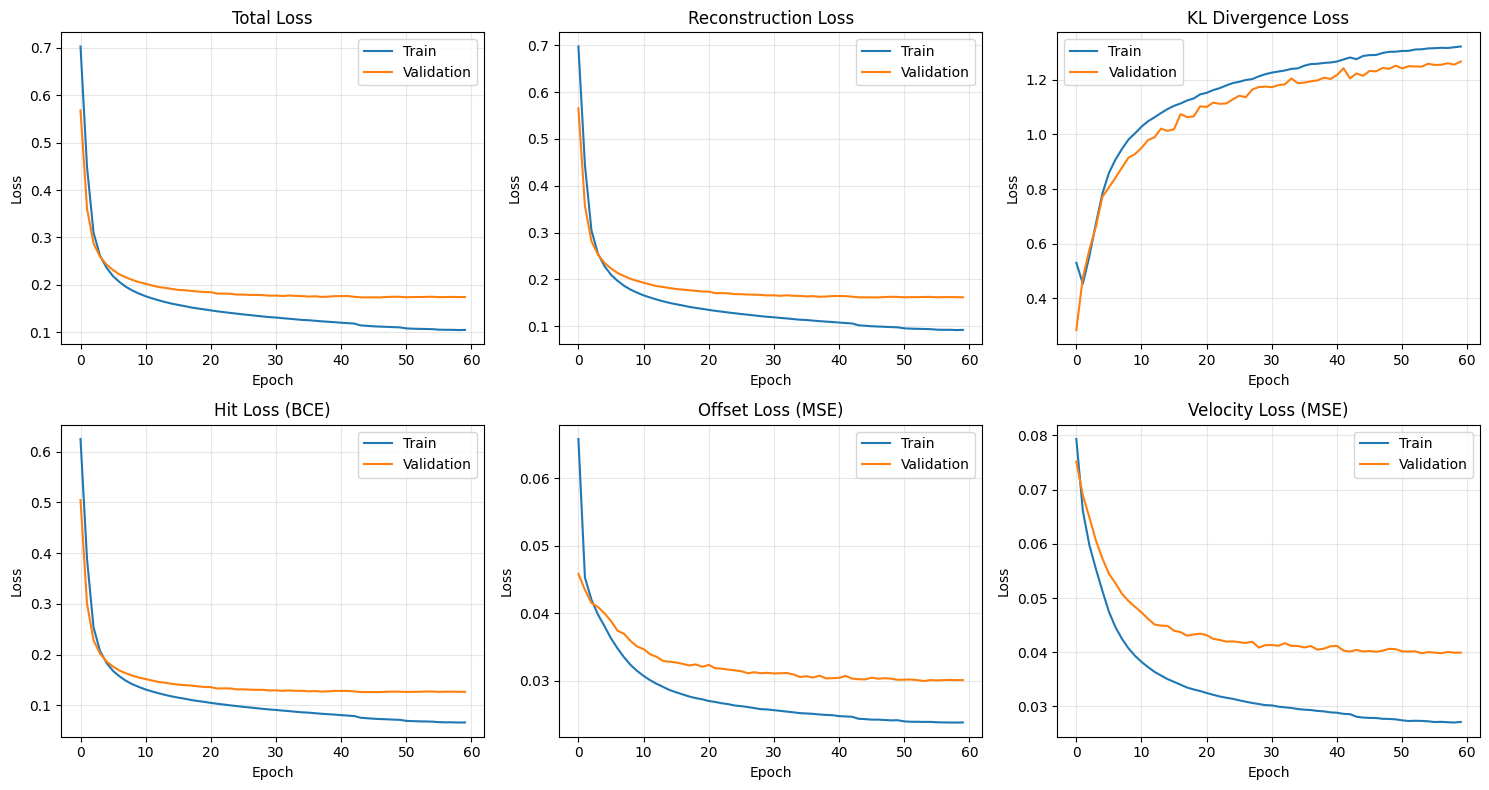

In [ ]:
def plot_training_history(history):
    """Plot training and validation losses."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    metrics = [
        ("total_loss", "Total Loss"),
        ("recon_loss", "Reconstruction Loss"),
        ("kl_loss", "KL Divergence Loss"),
        ("h_loss", "Hit Loss (BCE)"),
        ("o_loss", "Offset Loss (MSE)"),
        ("v_loss", "Velocity Loss (MSE)"),
    ]

    for ax, (metric, title) in zip(axes.flatten(), metrics):
        if metric in history.history:
            ax.plot(history.history[metric], label="Train")
        if f"val_{metric}" in history.history:
            ax.plot(history.history[f"val_{metric}"], label="Validation")
        ax.set_title(title)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "training_history.png"), dpi=150)
    plt.show()

plot_training_history(history)


### **Evaluate on Test Set**

In [ ]:
print("Evaluating on test set...")
test_results = cvae.evaluate(test_ds, verbose=1)
print("\nTest Results:")
for name, value in zip(cvae.metrics_names, test_results):
    print(f"  {name}: {value:.4f}")

Evaluating on test set...
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - h_loss: 0.1258 - kl_loss: 1.1817 - o_loss: 0.0295 - recon_loss: 0.1596 - total_loss: 0.1714 - v_loss: 0.0381

Test Results:
  total_loss: 0.1703
  recon_loss: 0.1585
  kl_loss: 1.1810
  h_loss: 0.1245
  o_loss: 0.0298
  v_loss: 0.0383


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


### **Save Final Model**

In [ ]:
# Save weights
cvae.save_weights(os.path.join(OUTPUT_DIR, "cvae_final.weights.h5"))
encoder.save(os.path.join(OUTPUT_DIR, "encoder_model.keras"))
decoder.save(os.path.join(OUTPUT_DIR, "decoder_model.keras"))

print("Models saved successfully!")
print("  - CVAE weights: cvae_final.weights.h5")
print("  - Encoder: encoder_model.keras")
print("  - Decoder: decoder_model.keras")

Models saved successfully!
  - CVAE weights: cvae_final.weights.h5
  - Encoder: encoder_model.keras
  - Decoder: decoder_model.keras


## **Testing and Evaluating**

### **Build CVAE**

In [ ]:
cvae.build(input_shape=[(None, 64, 9, 3), (None, COND_DIM)])
cvae.load_weights(os.path.join(OUTPUT_DIR, "cvae_final.weights.h5"))

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### **Generation Functions**

In [ ]:
def generate_drum_loop(cvae, genre_idx, bpm, num_samples=1):
    """
    Generate drum loops conditioned on genre and BPM.

    Args:
        cvae: Trained CVAE model
        genre_idx: Integer index of genre (0-17)
        bpm: Beats per minute (will be normalized)
        num_samples: Number of loops to generate

    Returns:
        Generated HOV tensors of shape (num_samples, 64, 9, 3)
    """
    # Create conditioning vector
    cond = np.zeros((num_samples, 19), dtype=np.float32)
    cond[:, genre_idx] = 1.0  # One-hot genre
    cond[:, 18] = np.clip(bpm / 300.0, 0.0, 1.0)  # Normalized BPM

    # Sample from prior (standard normal)
    z = np.random.normal(size=(num_samples, LATENT_DIM)).astype(np.float32)

    # Decode
    generated = cvae.decoder.predict([z, cond], verbose=0)

    return generated

def threshold_hits(generated, threshold=0.5):
    """
    Convert soft hit probabilities to binary hits.
    """
    result = generated.copy()
    result[..., 0] = (result[..., 0] > threshold).astype(np.float32)
    return result

# Genre name to index mapping
GENRE_TO_IDX = {
    "afrobeat": 0, "afrocuban": 1, "blues": 2, "country": 3,
    "dance": 4, "funk": 5, "gospel": 6, "highlife": 7,
    "hiphop": 8, "jazz": 9, "latin": 10, "middleeastern": 11,
    "neworleans": 12, "pop": 13, "punk": 14, "reggae": 15,
    "rock": 16, "soul": 17
}

CLASS_TO_PITCH = {
    0: 36,  # kick
    1: 38,  # snare
    2: 42,  # hh_closed
    3: 46,  # hh_open
    4: 45,  # tom_low
    5: 48,  # tom_mid
    6: 43,  # tom_floor
    7: 51,  # ride
    8: 49   # crash
}

def tensor_to_midi(X, save_path="generated.mid", bpm=100):
    midi = pm.PrettyMIDI(initial_tempo=bpm)
    drum = pm.Instrument(program=0, is_drum=True)
    T, M, _ = X.shape
    timestep = 60.0 / bpm / 4  # 16th notes

    for t in range(T):
        for m in range(M):
            if X[t, m, 0] > 0.5:  # hit
                start = t * timestep + X[t, m, 1] * timestep
                end = start + timestep * 0.5
                velocity = int(np.clip(X[t, m, 2] * 127, 1, 127))
                note = pm.Note(velocity=velocity, pitch=int(CLASS_TO_PITCH[m]), start=start, end=end)
                drum.notes.append(note)
    midi.instruments.append(drum)
    midi.write(save_path)
    print(f"Saved generated loop to {save_path}")

def generate_one_audio_sample(cvae, genre, bpm):
    generated = generate_drum_loop(cvae, GENRE_TO_IDX[genre], bpm=bpm, num_samples=1)
    generated = threshold_hits(generated)
    gen = generated[0]
    file_name = f"{genre}_{bpm}"

    tensor_to_midi(gen, f"{file_name}.mid", bpm)
    !timidity {file_name}.mid -Ow -o {file_name}.wav

    return Audio(f"{file_name}.wav")

def generate_audio_samples(cvae, genre, bpm, num_samples=1, base_name=None):
    generated = generate_drum_loop(cvae, GENRE_TO_IDX[genre], bpm, num_samples)
    generated = threshold_hits(generated)

    if base_name is None:
        base_name = f"{genre}_{bpm}"

    audio_objects = []

    for i in range(num_samples):
        gen = generated[i]
        file_stem = f"{base_name}_{i+1}"
        midi_path = f"{file_stem}.mid"
        wav_path = f"{file_stem}.wav"
        tensor_to_midi(gen, midi_path, bpm)
        !timidity {midi_path} -Ow -o {wav_path} > /dev/null
        audio_objects.append(Audio(wav_path))

    return audio_objects


### **Visualize Generated Samples**

Generating sample drum loops...


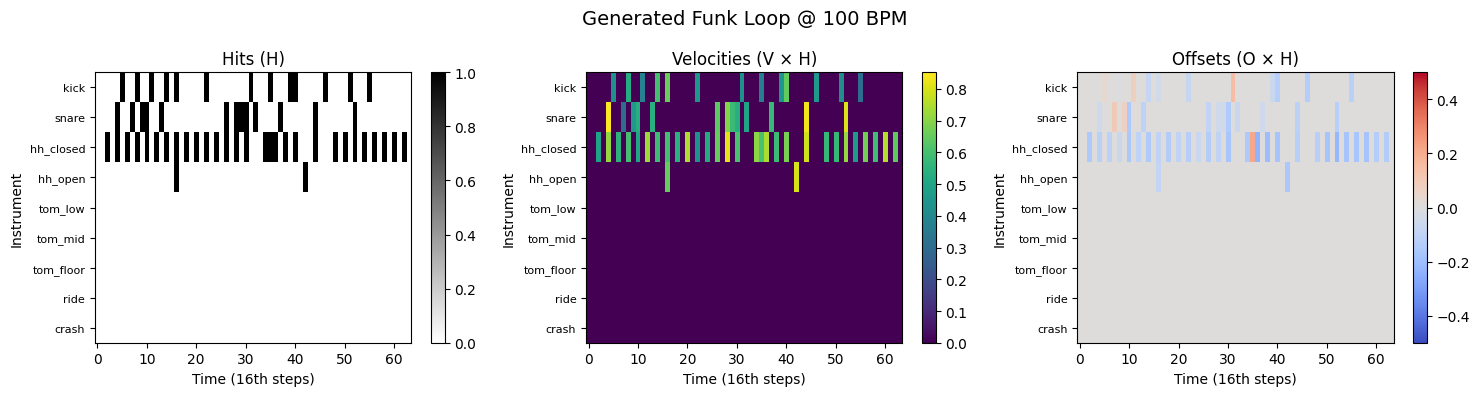

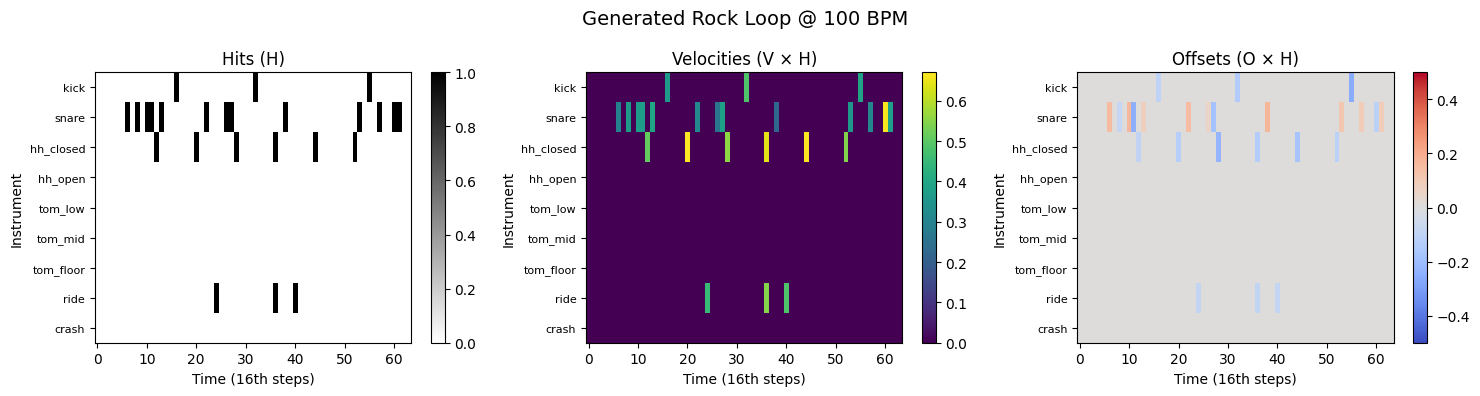

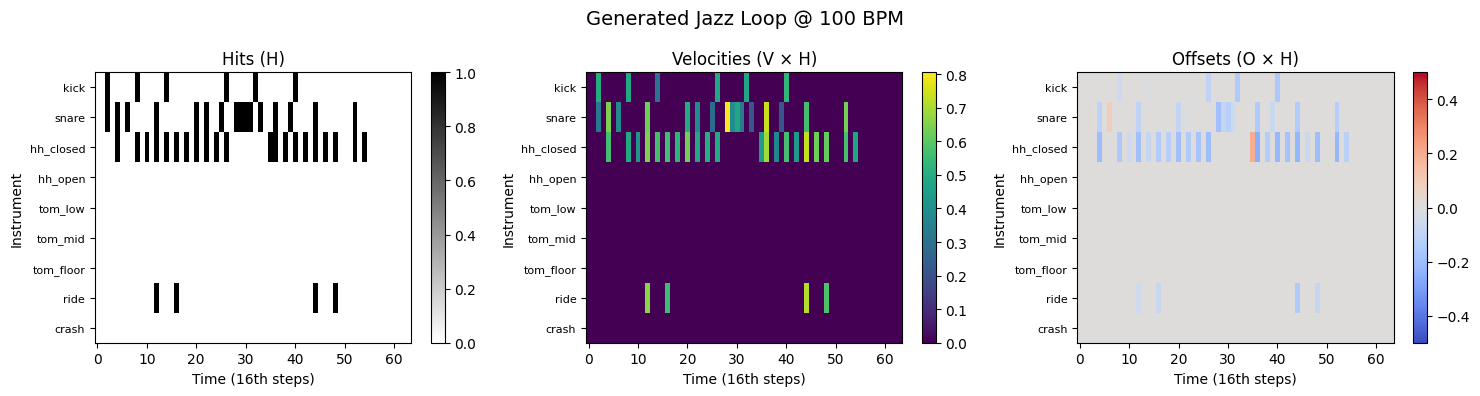

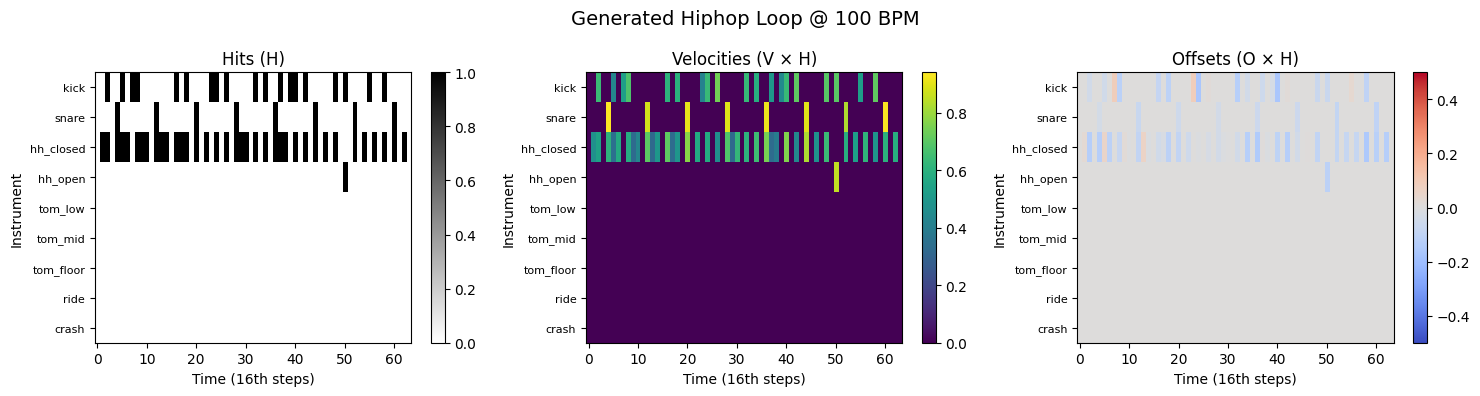

In [ ]:
def visualize_generated(generated, title="Generated Drum Loop"):
    """Visualize a single generated drum loop."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    H = generated[..., 0]
    O = generated[..., 1]
    V = generated[..., 2]

    # Hits
    im0 = axes[0].imshow(H.T, aspect="auto", interpolation="nearest", cmap="binary")
    axes[0].set_title("Hits (H)")
    axes[0].set_xlabel("Time (16th steps)")
    axes[0].set_ylabel("Instrument")
    axes[0].set_yticks(range(9))
    axes[0].set_yticklabels([DRUM_CLASSES[i] for i in range(9)], fontsize=8)
    plt.colorbar(im0, ax=axes[0])

    # Velocities (masked by hits)
    im1 = axes[1].imshow((V * H).T, aspect="auto", interpolation="nearest", cmap="viridis")
    axes[1].set_title("Velocities (V × H)")
    axes[1].set_xlabel("Time (16th steps)")
    axes[1].set_ylabel("Instrument")
    axes[1].set_yticks(range(9))
    axes[1].set_yticklabels([DRUM_CLASSES[i] for i in range(9)], fontsize=8)
    plt.colorbar(im1, ax=axes[1])

    # Offsets (masked by hits)
    im2 = axes[2].imshow((O * H).T, aspect="auto", interpolation="nearest", cmap="coolwarm", vmin=-0.5, vmax=0.5)
    axes[2].set_title("Offsets (O × H)")
    axes[2].set_xlabel("Time (16th steps)")
    axes[2].set_ylabel("Instrument")
    axes[2].set_yticks(range(9))
    axes[2].set_yticklabels([DRUM_CLASSES[i] for i in range(9)], fontsize=8)
    plt.colorbar(im2, ax=axes[2])

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Generate and visualize samples for different genres
print("Generating sample drum loops...")

for genre in ["funk", "rock", "jazz", "hiphop"]:
    generated = generate_drum_loop(cvae, GENRE_TO_IDX[genre], bpm=100, num_samples=1)
    generated = threshold_hits(generated, threshold=0.5)
    visualize_generated(generated[0], title=f"Generated {genre.capitalize()} Loop @ 100 BPM")


### **Compare Original vs Reconstructed**

Comparing original vs reconstructed samples...


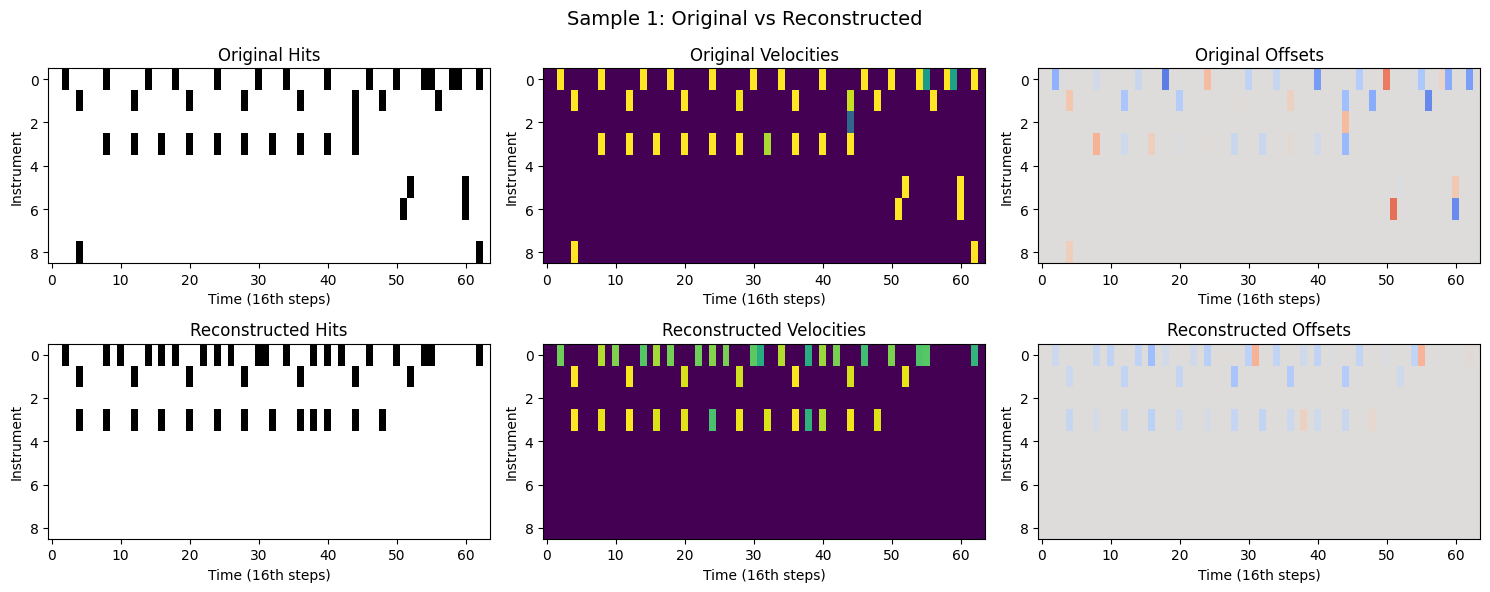

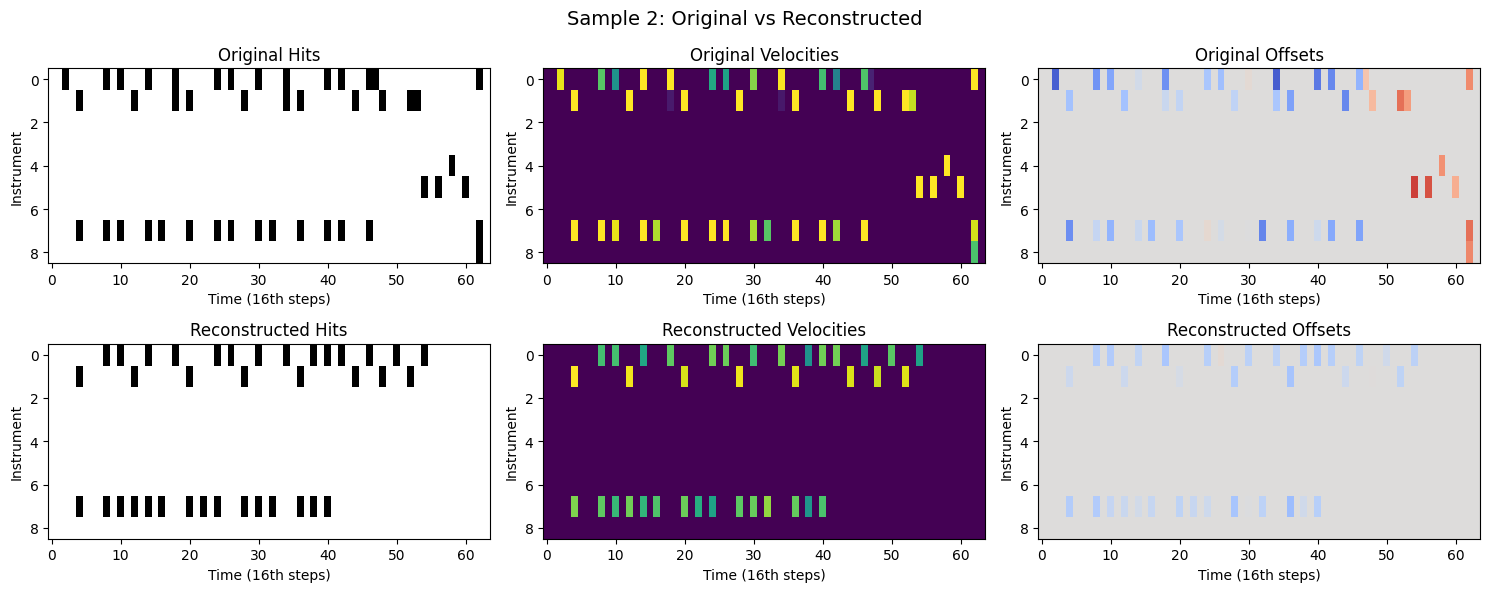

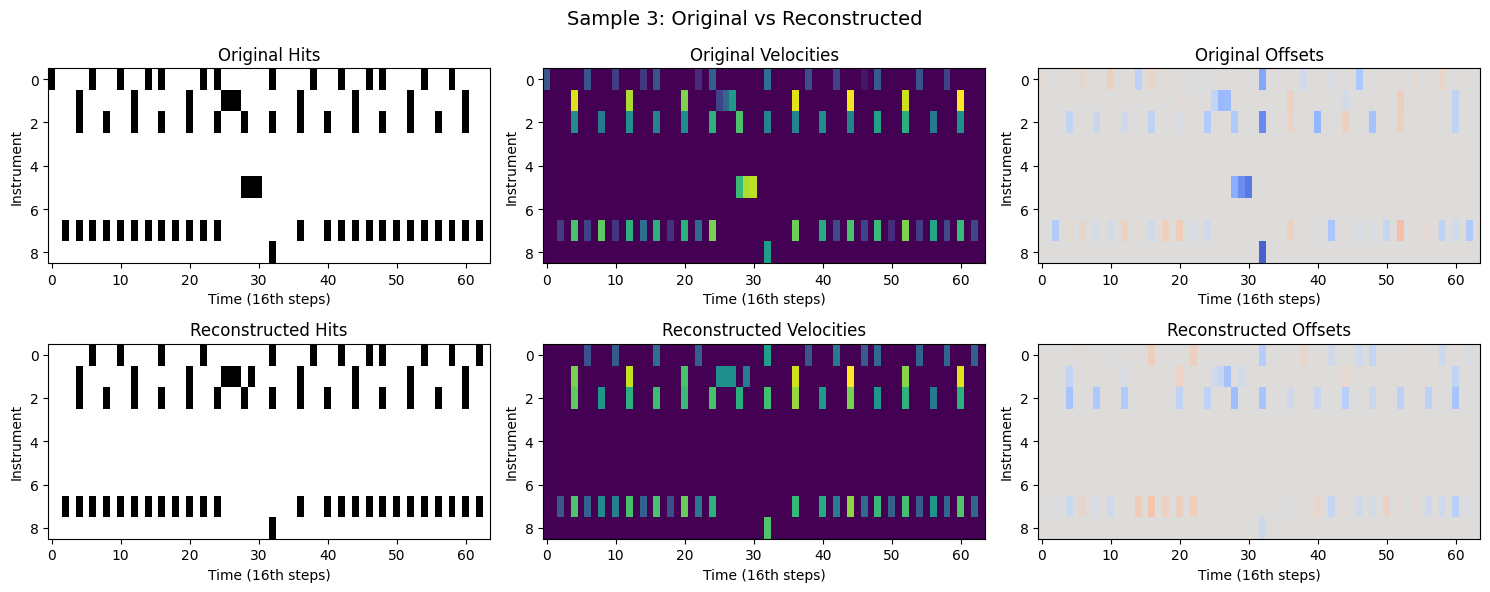

In [ ]:
def compare_reconstruction(cvae, dataset, num_samples=3):
    """Compare original samples with their reconstructions."""
    for (x_batch, cond_batch), _ in dataset.take(1):
        x_batch = x_batch.numpy()
        cond_batch = cond_batch.numpy()

        # Get reconstructions
        z_mean, z_log_var, z = cvae.encoder.predict([x_batch, cond_batch], verbose=0)
        reconstructed = cvae.decoder.predict([z, cond_batch], verbose=0)
        reconstructed = threshold_hits(reconstructed, threshold=0.5)

        for i in range(min(num_samples, x_batch.shape[0])):
            fig, axes = plt.subplots(2, 3, figsize=(15, 6))

            # Original
            orig = x_batch[i]
            axes[0, 0].imshow(orig[..., 0].T, aspect="auto", cmap="binary")
            axes[0, 0].set_title("Original Hits")
            axes[0, 1].imshow((orig[..., 2] * orig[..., 0]).T, aspect="auto", cmap="viridis")
            axes[0, 1].set_title("Original Velocities")
            axes[0, 2].imshow((orig[..., 1] * orig[..., 0]).T, aspect="auto", cmap="coolwarm", vmin=-0.5, vmax=0.5)
            axes[0, 2].set_title("Original Offsets")

            # Reconstructed
            recon = reconstructed[i]
            axes[1, 0].imshow(recon[..., 0].T, aspect="auto", cmap="binary")
            axes[1, 0].set_title("Reconstructed Hits")
            axes[1, 1].imshow((recon[..., 2] * recon[..., 0]).T, aspect="auto", cmap="viridis")
            axes[1, 1].set_title("Reconstructed Velocities")
            axes[1, 2].imshow((recon[..., 1] * recon[..., 0]).T, aspect="auto", cmap="coolwarm", vmin=-0.5, vmax=0.5)
            axes[1, 2].set_title("Reconstructed Offsets")

            for ax in axes.flatten():
                ax.set_xlabel("Time (16th steps)")
                ax.set_ylabel("Instrument")

            plt.suptitle(f"Sample {i+1}: Original vs Reconstructed", fontsize=14)
            plt.tight_layout()
            plt.show()

print("Comparing original vs reconstructed samples...")
compare_reconstruction(cvae, val_ds, num_samples=3)


### **Generate audio**

In [ ]:
samples = generate_audio_samples(cvae, "dance", 100, 5)

Saved generated loop to dance_100_1.mid
Saved generated loop to dance_100_2.mid
Saved generated loop to dance_100_3.mid
Saved generated loop to dance_100_4.mid
Saved generated loop to dance_100_5.mid


In [ ]:
for i, a in enumerate(samples, start=1):
    print(f"Sample {i}")
    display(a)


In [ ]:
funk_samples = generate_audio_samples(cvae, "funk", 100, 5)
for i, a in enumerate(funk_samples, start=1):
    print(f"Funk Sample {i}")
    display(a)

In [ ]:
jazz_sample = generate_audio_samples(cvae, "jazz", 100)
display(jazz_sample[0])

In [ ]:
pop_sample = generate_audio_samples(cvae, "pop", 160)
display(pop_sample[0])

Saved generated loop to pop_160_1.mid


## **SVM**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

def get_latents(ds):
    Z_list = []
    y_list = []

    for i, features in enumerate(ds):
        X_batch, cond_batch = process_batch(features)
        z_mean, z_log_var, z = encoder([X_batch, cond_batch], training=False)

        Z_list.append(z_mean.numpy())
        y_list.append(features["style"]["primary"].numpy())

    Z = np.concatenate(Z_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    return Z, y

Z_train, y_train = get_latents(dataset_train)
Z_val, y_val = get_latents(dataset_val)

svm_clf = LinearSVC(C=1.0, class_weight="balanced", max_iter=5000)
svm_clf.fit(Z_train, y_train)

y_pred = svm_clf.predict(Z_val)
val_acc = accuracy_score(y_val, y_pred)
print(f"\nValidation accuracy: {val_acc * 100:.2f}%\n")

print("Classification report:")
print(classification_report(y_val, y_pred, digits=3))


Validation accuracy: 51.26%

Classification report:
              precision    recall  f1-score   support

           0      0.899     0.781     0.836       114
           1      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0
           4      0.000     0.000     0.000         0
           5      0.806     0.682     0.739       384
           6      0.000     0.000     0.000        67
           8      0.046     0.333     0.081        12
           9      0.205     0.617     0.308        81
          10      0.851     0.552     0.669       466
          12      0.000     0.000     0.000         0
          13      0.378     0.274     0.318       124
          14      0.000     0.000     0.000       119
          15      0.000     0.000     0.000         0
          16      0.582     0.521     0.550       618
          17      0.000     0.000     0.000         1

    accuracy                          0.513      1986
   macro avg      0.251    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

/tmp/ipython-input-3708289287.py:5: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)


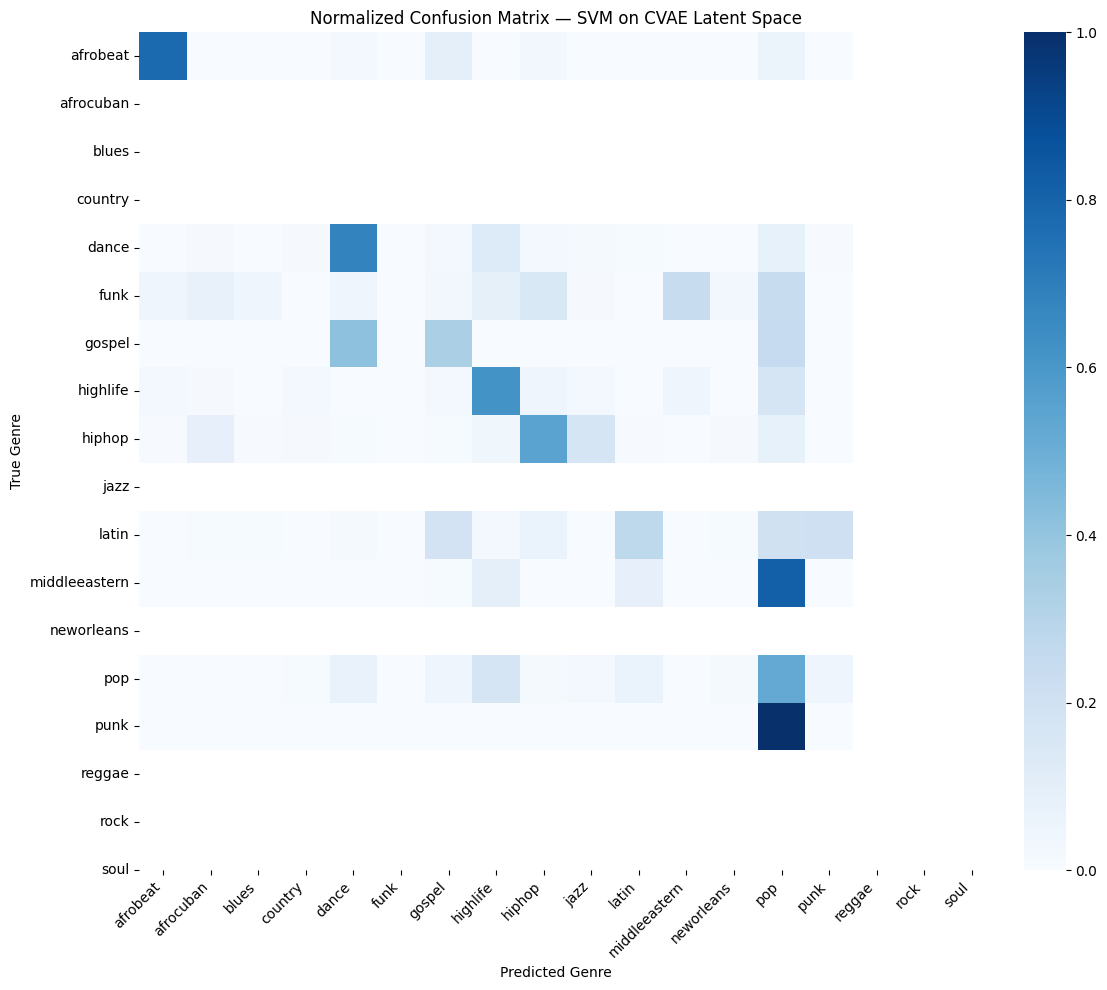

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}
style_labels = [idx_to_genre[i] for i in range(18)]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_norm,
    annot=False,
    cmap="Blues",
    xticklabels=style_labels,
    yticklabels=style_labels,
    cbar=True
)
plt.title("Normalized Confusion Matrix — SVM on CVAE Latent Space")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **CNN-Based Genre Classification**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### **Build CNN Classifier Architecture**


In [ ]:
def build_cnn_classifier(input_shape=(64, 9, 3), num_classes=18):
    """
    Build a CNN classifier for drum loop genre classification.

    Architecture:
    - Conv2D layers to capture temporal and instrument patterns
    - Batch normalization for stable training
    - Dropout for regularization
    - Global pooling to handle variable-length sequences
    - Dense layers for classification

    Args:
        input_shape: Shape of input (time_steps, instruments, features)
        num_classes: Number of genre classes

    Returns:
        Compiled Keras model
    """
    inputs = layers.Input(shape=input_shape, name="drum_input")

    # First conv block - capture local patterns
    x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)  # Pool only in time dimension
    x = layers.Dropout(0.25)(x)

    # Second conv block - capture mid-level features
    x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.25)(x)

    # Third conv block - capture high-level features
    x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Dropout(0.25)(x)

    # Fourth conv block - deepest features
    x = layers.Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)  # Reduce to fixed-size representation

    # Dense layers for classification
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax", name="genre_output")(x)

    model = Model(inputs=inputs, outputs=outputs, name="cnn_genre_classifier")

    return model

# Build and compile the model
cnn_classifier = build_cnn_classifier(input_shape=(64, 9, 3), num_classes=NUM_STYLES)

cnn_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

### **Calculate Class Weights for Imbalanced Data**


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weights(dataset):
    """Calculate class weights to handle imbalanced dataset."""
    all_labels = []

    for features in dataset:
        labels = features["style"]["primary"].numpy()
        all_labels.extend(labels)

    all_labels = np.array(all_labels)
    unique_classes = np.unique(all_labels)

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=all_labels
    )

    # Create dictionary mapping class index to weight
    class_weight_dict = {int(cls): weight for cls, weight in zip(unique_classes, class_weights)}

    # Print class distribution and weights
    print("\nClass Distribution and Weights:")
    print("=" * 70)
    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    for cls in sorted(unique_classes):
        count = np.sum(all_labels == cls)
        weight = class_weight_dict[cls]
        genre_name = idx_to_genre.get(cls, f"class_{cls}")
        print(f"{genre_name:>15s}: {count:4d} samples, weight: {weight:.3f}")

    print("=" * 70)

    return class_weight_dict

# Calculate class weights from training data
class_weights = calculate_class_weights(dataset_train)

print("=" * 60)
print("CNN CLASSIFIER SUMMARY")
print("=" * 60)
cnn_classifier.summary()


Class Distribution and Weights:
       afrobeat:  759 samples, weight: 1.292
      afrocuban:  805 samples, weight: 1.218
          blues:   80 samples, weight: 12.257
        country:  115 samples, weight: 8.526
          dance:  714 samples, weight: 1.373
           funk: 1534 samples, weight: 0.639
       highlife:   45 samples, weight: 21.790
         hiphop:  665 samples, weight: 1.474
           jazz: 2657 samples, weight: 0.369
          latin: 2716 samples, weight: 0.361
  middleeastern:  116 samples, weight: 8.453
     neworleans:  696 samples, weight: 1.409
            pop:  101 samples, weight: 9.708
           punk:   87 samples, weight: 11.270
         reggae:  156 samples, weight: 6.285
           rock: 5161 samples, weight: 0.190
           soul:  262 samples, weight: 3.742
CNN CLASSIFIER SUMMARY


Model: "cnn_genre_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ drum_input (InputLayer)         │ (None, 64, 9, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 9, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 9, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 9, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 9, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 9, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 9, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 9, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ genre_output (Dense)            │ (None, 18)             │         2,32

 Total params: 492,370 (1.88 MB)

 Trainable params: 490,898 (1.87 MB)

 Non-trainable params: 1,472 (5.75 KB)

### **Alternative: Focal Loss for Imbalanced Classes**


In [ ]:
class FocalLoss(keras.losses.Loss):
    """
    Focal Loss for handling class imbalance.
    Focuses training on hard examples and down-weights easy examples.
    """
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Convert labels to one-hot
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])

        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Calculate focal loss
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = self.alpha * tf.pow(1 - y_pred, self.gamma) * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

# Alternative: Build classifier with Focal Loss
def build_cnn_with_focal_loss(input_shape=(64, 9, 3), num_classes=18):
    """Build CNN classifier with Focal Loss for better handling of imbalance."""
    model = build_cnn_classifier(input_shape, num_classes)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=FocalLoss(alpha=0.25, gamma=2.0),
        metrics=["accuracy"]
    )

    return model

# Uncomment to use Focal Loss instead of class weights:
# cnn_classifier = build_cnn_with_focal_loss()

### **Data Augmentation for Minority Classes**


In [ ]:
def augment_drum_pattern(X):
    """
    Apply augmentation to drum patterns to increase diversity.
    - Random velocity scaling
    - Random timing jitter
    - Random instrument dropout
    """
    X_aug = X.copy()

    # Random velocity scaling (±20%)
    if np.random.random() > 0.5:
        velocity_scale = np.random.uniform(0.8, 1.2)
        X_aug[..., 2] = np.clip(X_aug[..., 2] * velocity_scale, 0, 1)

    # Random timing jitter (±10% of offset range)
    if np.random.random() > 0.5:
        offset_jitter = np.random.uniform(-0.05, 0.05, size=X_aug[..., 1].shape)
        X_aug[..., 1] = np.clip(X_aug[..., 1] + offset_jitter, -0.5, 0.5)

    # Random instrument dropout (5% chance per hit)
    if np.random.random() > 0.7:
        dropout_mask = np.random.random(X_aug[..., 0].shape) > 0.05
        X_aug[..., 0] = X_aug[..., 0] * dropout_mask

    return X_aug

def prepare_cnn_dataset_with_augmentation(raw_ds, augment_minority=True, minority_threshold=200):
    """
    Prepare dataset with augmentation for minority classes.

    Args:
        raw_ds: Raw dataset
        augment_minority: Whether to augment minority classes
        minority_threshold: Classes with fewer samples than this are augmented
    """
    def generator():
        # First, count class distribution
        class_counts = {}
        all_samples = []

        for features in raw_ds:
            X_batch, _ = process_batch(features)
            y_batch = features["style"]["primary"].numpy()

            for x, y in zip(X_batch, y_batch):
                all_samples.append((x, y))
                class_counts[y] = class_counts.get(y, 0) + 1

        # Identify minority classes
        minority_classes = {cls for cls, count in class_counts.items()
                          if count < minority_threshold} if augment_minority else set()

        print(f"\nAugmenting {len(minority_classes)} minority classes: {minority_classes}")

        # Yield original samples
        for x, y in all_samples:
            yield x, y

        # Yield augmented samples for minority classes
        if augment_minority:
            for x, y in all_samples:
                if y in minority_classes:
                    # Create 2 augmented versions
                    for _ in range(2):
                        x_aug = augment_drum_pattern(x)
                        yield x_aug, y

    output_signature = (
        tf.TensorSpec(shape=(64, 9, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    ds = ds.shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)

    return ds

# Create augmented training dataset
print("\nPreparing augmented training dataset...")
cnn_train_ds_augmented = prepare_cnn_dataset_with_augmentation(
    dataset_train,
    augment_minority=True,
    minority_threshold=200
)

# %% [code]
def prepare_cnn_dataset(raw_ds, cache=False):
    """Convert raw dataset to (X, genre_label) pairs for CNN training."""
    def generator():
        for features in raw_ds:
            X_batch, _ = process_batch(features)
            y_batch = features["style"]["primary"].numpy()

            for x, y in zip(X_batch, y_batch):
                yield x, y

    output_signature = (
        tf.TensorSpec(shape=(64, 9, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)

    if cache:
        ds = ds.cache()

    ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

# Create CNN training datasets
print("Preparing CNN training datasets...")
cnn_train_ds = prepare_cnn_dataset(dataset_train, cache=False)
cnn_val_ds = prepare_cnn_dataset(dataset_val, cache=False)
cnn_test_ds = prepare_cnn_dataset(dataset_test, cache=False)
print("CNN datasets ready!")



Preparing augmented training dataset...
Preparing CNN training datasets...
CNN datasets ready!


### **Train CNN Classifier**

In [ ]:
# Callbacks for CNN training
cnn_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1,
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, "cnn_classifier_best.weights.h5"),
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
        mode='max'
    ),
]

class_weights = calculate_class_weights(dataset_train)

# Train the CNN classifier
print("Starting CNN classifier training...")
cnn_history = cnn_classifier.fit(
    cnn_train_ds_augmented,
    epochs=50,
    validation_data=cnn_val_ds,
    callbacks=cnn_callbacks,
    class_weight=class_weights,
    verbose=1
)



Class Distribution and Weights:
       afrobeat:  759 samples, weight: 1.292
      afrocuban:  805 samples, weight: 1.218
          blues:   80 samples, weight: 12.257
        country:  115 samples, weight: 8.526
          dance:  714 samples, weight: 1.373
           funk: 1534 samples, weight: 0.639
       highlife:   45 samples, weight: 21.790
         hiphop:  665 samples, weight: 1.474
           jazz: 2657 samples, weight: 0.369
          latin: 2716 samples, weight: 0.361
  middleeastern:  116 samples, weight: 8.453
     neworleans:  696 samples, weight: 1.409
            pop:  101 samples, weight: 9.708
           punk:   87 samples, weight: 11.270
         reggae:  156 samples, weight: 6.285
           rock: 5161 samples, weight: 0.190
           soul:  262 samples, weight: 3.742
Starting CNN classifier training...
Epoch 1/50

Augmenting 7 minority classes: {np.int64(2), np.int64(3), np.int64(7), np.int64(11), np.int64(13), np.int64(14), np.int64(15)}
    565/Unknown 69s 25ms

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.46324, saving model to /content/drive/Shareddrives/groove_gen/root_run2/cnn_classifier_best.weights.h5
565/565 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.9269 - loss: 0.1006 - val_accuracy: 0.4632 - val_loss: 5.2720 - learning_rate: 0.0010
Epoch 2/50

Augmenting 7 minority classes: {np.int64(2), np.int64(3), np.int64(7), np.int64(11), np.int64(13), np.int64(14), np.int64(15)}
549/565 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8693 - loss: 0.1893
Epoch 2: val_accuracy did not improve from 0.46324
565/565 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.8700 - loss: 0.1888 - val_accuracy: 0.4632 - val_loss: 8.4389 - learning_rate: 0.0010
Epoch 3/50

Augmenting 7 minority classes: {np.int64(2), np.int64(3), np.int64(7), np.int64(11), np.int64(13), np.int64(14), np.int64(15)}
552/565 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8910 - loss: 0.1450
Epoch 3: val_accuracy did not improve from 0.46324
565/565 ━━━━━━━━━━━━━━━━━━━━ 54s 1

### **Save CNN Classifier**

In [ ]:
import pickle

cnn_classifier.save(os.path.join(OUTPUT_DIR, "cnn_genre_classifier.keras"))
cnn_classifier.save_weights(os.path.join(OUTPUT_DIR, "cnn_classifier_final.weights.h5"))

print("CNN classifier saved successfully!")
print(f"  - Full model: {os.path.join(OUTPUT_DIR, 'cnn_genre_classifier.keras')}")
print(f"  - Weights: {os.path.join(OUTPUT_DIR, 'cnn_classifier_final.weights.h5')}")

with open(os.path.join(OUTPUT_DIR, "cnn_history.pkl"), "wb") as f:
    pickle.dump(cnn_history.history, f)
print("Training history saved!")

CNN classifier saved successfully!
  - Full model: /content/drive/Shareddrives/groove_gen/root_run2/cnn_genre_classifier.keras
  - Weights: /content/drive/Shareddrives/groove_gen/root_run2/cnn_classifier_final.weights.h5
Training history saved!


### **Load CNN Classifier**

In [ ]:
import pickle

cnn_classifier = keras.models.load_model(os.path.join(OUTPUT_DIR, "cnn_genre_classifier.keras"))
cnn_classifier.load_weights(os.path.join(OUTPUT_DIR, "cnn_classifier_final.weights.h5"))

with open(os.path.join(OUTPUT_DIR, "cnn_history.pkl"), "rb") as f:
    history_dict = pickle.load(f)

class HistoryWrapper:
    def __init__(self, history_dict):
        self.history = history_dict

print("CNN classifier loaded successfully!")
print(f"  - Full model: {os.path.join(OUTPUT_DIR, 'cnn_genre_classifier.keras')}")
print(f"  - Weights: {os.path.join(OUTPUT_DIR, 'cnn_classifier_final.weights.h5')}")

cnn_history = HistoryWrapper(history_dict)

CNN classifier loaded successfully!
  - Full model: /content/drive/Shareddrives/groove_gen/root_run2/cnn_genre_classifier.keras
  - Weights: /content/drive/Shareddrives/groove_gen/root_run2/cnn_classifier_final.weights.h5


### **Evaluate CNN Classifier**

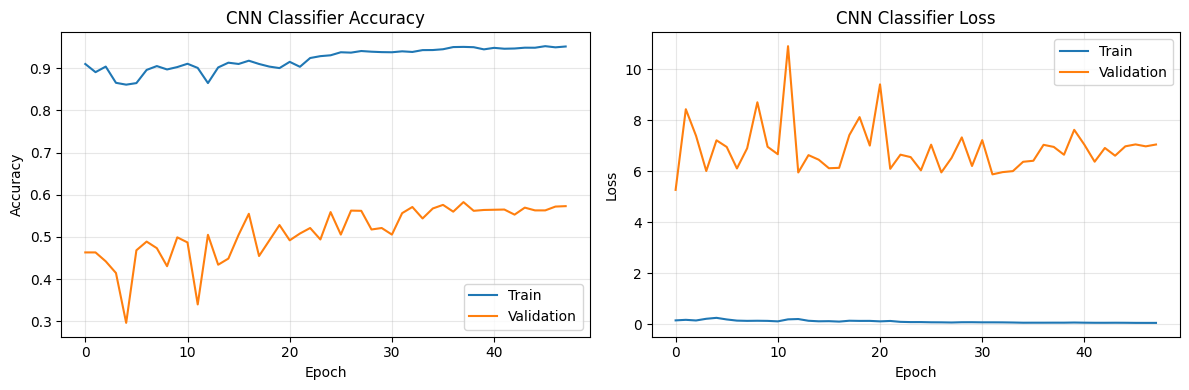

Evaluating CNN classifier on test set...
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.5646 - loss: 5.6272

Test Accuracy: 56.32%
Test Loss: 5.7064


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
def plot_cnn_training_history(history):
    """Plot CNN training history."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].plot(history.history["accuracy"], label="Train")
    axes[0].plot(history.history["val_accuracy"], label="Validation")
    axes[0].set_title("CNN Classifier Accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history["loss"], label="Train")
    axes[1].plot(history.history["val_loss"], label="Validation")
    axes[1].set_title("CNN Classifier Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "cnn_training_history.png"), dpi=150)
    plt.show()

plot_cnn_training_history(cnn_history)

# Evaluate on test set
print("Evaluating CNN classifier on test set...")
test_loss, test_acc = cnn_classifier.evaluate(cnn_test_ds, verbose=1)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


### **Detailed Evaluation and Confusion Matrix**


Classification Report:
              precision    recall  f1-score   support

    afrobeat      0.734     0.753     0.744        77
        funk      0.846     0.466     0.601       519
    highlife      1.000     0.667     0.800        93
      hiphop      0.526     0.833     0.645        96
        jazz      0.133     0.507     0.211        71
       latin      0.992     0.769     0.867       342
         pop      0.000     0.000     0.000        52
        punk      1.000     0.804     0.891        56
      reggae      0.000     0.000     0.000       118
        rock      0.444     0.593     0.508       332
        soul      0.747     0.585     0.656       277

   micro avg      0.624     0.563     0.592      2033
   macro avg      0.584     0.543     0.538      2033
weighted avg      0.688     0.563     0.599      2033



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


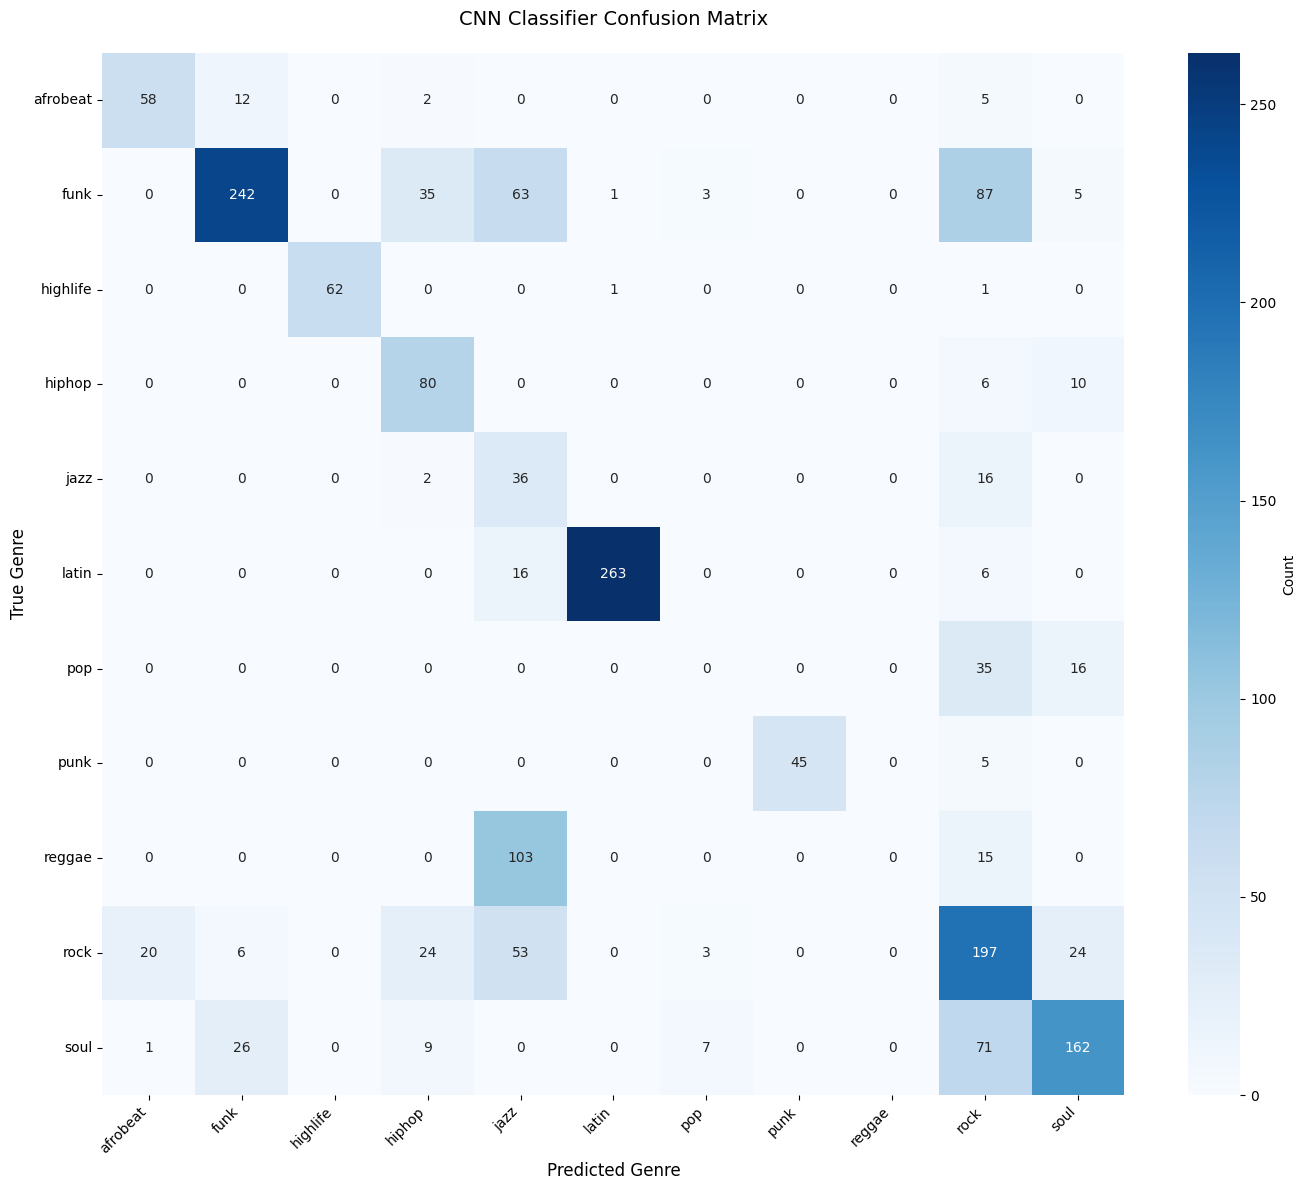

In [ ]:
def evaluate_cnn_detailed(model, test_ds):
    """Generate detailed evaluation metrics and confusion matrix."""
    y_true = []
    y_pred = []

    for X_batch, y_batch in test_ds:
        predictions = model.predict(X_batch, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(y_batch.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Classification report
    print("\nClassification Report:")
    print("=" * 60)

    # Create genre name mapping
    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    # Get unique labels actually present in y_true
    unique_labels = np.unique(y_true)
    # Filter target_names to match only the unique labels present
    filtered_target_names = [idx_to_genre.get(i, f"class_{i}") for i in unique_labels]

    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=filtered_target_names, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=filtered_target_names,
        yticklabels=filtered_target_names,
        cbar_kws={'label': 'Count'}
    )
    plt.title("CNN Classifier Confusion Matrix", fontsize=14, pad=20)
    plt.xlabel("Predicted Genre", fontsize=12)
    plt.ylabel("True Genre", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "cnn_confusion_matrix.png"), dpi=150)
    plt.show()

    return y_true, y_pred, cm

y_true, y_pred, cm = evaluate_cnn_detailed(cnn_classifier, cnn_test_ds)


In [ ]:
def generate_drum_loop(cvae, genre_idx, bpm, num_samples=1):
    """
    Generate drum loops conditioned on genre and BPM.

    Args:
        cvae: Trained CVAE model
        genre_idx: Integer index of genre (0-17)
        bpm: Beats per minute (will be normalized)
        num_samples: Number of loops to generate

    Returns:
        Generated HOV tensors of shape (num_samples, 64, 9, 3)
    """
    # Create conditioning vector
    cond = np.zeros((num_samples, 19), dtype=np.float32)
    cond[:, genre_idx] = 1.0  # One-hot genre
    cond[:, 18] = np.clip(bpm / 300.0, 0.0, 1.0)  # Normalized BPM

    # Sample from prior (standard normal)
    z = np.random.normal(size=(num_samples, LATENT_DIM)).astype(np.float32)

    # Decode
    generated = cvae.decoder.predict([z, cond], verbose=0)

    return generated

def threshold_hits(generated, threshold=0.5):
    """
    Convert soft hit probabilities to binary hits.
    """
    result = generated.copy()
    result[..., 0] = (result[..., 0] > threshold).astype(np.float32)
    return result

# Genre name to index mapping
GENRE_TO_IDX = {
    "afrobeat": 0, "afrocuban": 1, "blues": 2, "country": 3,
    "dance": 4, "funk": 5, "gospel": 6, "highlife": 7,
    "hiphop": 8, "jazz": 9, "latin": 10, "middleeastern": 11,
    "neworleans": 12, "pop": 13, "punk": 14, "reggae": 15,
    "rock": 16, "soul": 17
}

CLASS_TO_PITCH = {
    0: 36,  # kick
    1: 38,  # snare
    2: 42,  # hh_closed
    3: 46,  # hh_open
    4: 45,  # tom_low
    5: 48,  # tom_mid
    6: 43,  # tom_floor
    7: 51,  # ride
    8: 49   # crash
}

def tensor_to_midi(X, save_path="generated.mid", bpm=100):
    midi = pm.PrettyMIDI(initial_tempo=bpm)
    drum = pm.Instrument(program=0, is_drum=True)
    T, M, _ = X.shape
    timestep = 60.0 / bpm / 4  # 16th notes

    for t in range(T):
        for m in range(M):
            if X[t, m, 0] > 0.5:  # hit
                start = t * timestep + X[t, m, 1] * timestep
                end = start + timestep * 0.5
                velocity = int(np.clip(X[t, m, 2] * 127, 1, 127))
                note = pm.Note(velocity=velocity, pitch=int(CLASS_TO_PITCH[m]), start=start, end=end)
                drum.notes.append(note)
    midi.instruments.append(drum)
    midi.write(save_path)
    print(f"Saved generated loop to {save_path}")

def generate_one_audio_sample(cvae, genre, bpm):
    generated = generate_drum_loop(cvae, GENRE_TO_IDX[genre], bpm=bpm, num_samples=1)
    generated = threshold_hits(generated)
    gen = generated[0]
    file_name = f"{genre}_{bpm}"

    tensor_to_midi(gen, f"{file_name}.mid", bpm)
    !timidity {file_name}.mid -Ow -o {file_name}.wav

    return Audio(f"{file_name}.wav")

def generate_audio_samples(cvae, genre, bpm, num_samples=1, base_name=None):
    generated = generate_drum_loop(cvae, GENRE_TO_IDX[genre], bpm, num_samples)
    generated = threshold_hits(generated)

    if base_name is None:
        base_name = f"{genre}_{bpm}"

    audio_objects = []

    for i in range(num_samples):
        gen = generated[i]
        file_stem = f"{base_name}_{i+1}"
        midi_path = f"{file_stem}.mid"
        wav_path = f"{file_stem}.wav"
        tensor_to_midi(gen, midi_path, bpm)
        !timidity {midi_path} -Ow -o {wav_path} > /dev/null
        audio_objects.append(Audio(wav_path))

    return audio_objects

def classify_generated_loop(cnn_model, generated_hov):
    """
    Classify a generated drum loop using the CNN classifier.

    Args:
        cnn_model: Trained CNN classifier
        generated_hov: Generated HOV array of shape (64, 9, 3)

    Returns:
        predicted_genre_idx: Predicted genre index
        confidence: Confidence score (probability)
        all_probs: All genre probabilities
    """
    # Add batch dimension
    x = np.expand_dims(generated_hov, axis=0)

    # Get predictions
    probs = cnn_model.predict(x, verbose=0)[0]

    predicted_idx = np.argmax(probs)
    confidence = probs[predicted_idx]

    return predicted_idx, confidence, probs

def generate_and_classify(cvae, cnn_model, genre, bpm, num_samples=5):
    """
    Generate drum loops and classify them with the CNN.

    Args:
        cvae: Trained CVAE model
        cnn_model: Trained CNN classifier
        genre: Target genre name
        bpm: Beats per minute
        num_samples: Number of samples to generate

    Returns:
        results: List of (generated_hov, predicted_genre, confidence, all_probs)
    """
    genre_idx = GENRE_TO_IDX[genre]
    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    # Generate samples
    generated = generate_drum_loop(cvae, genre_idx, bpm, num_samples)
    generated = threshold_hits(generated, threshold=0.5)

    results = []
    print(f"\nGenerating and classifying {num_samples} {genre} loops at {bpm} BPM:")
    print("=" * 80)

    for i, gen_sample in enumerate(generated):
        pred_idx, confidence, all_probs = classify_generated_loop(cnn_model, gen_sample)
        pred_genre = idx_to_genre.get(pred_idx, f"unknown_{pred_idx}")

        # Get top 3 predictions
        top3_indices = np.argsort(all_probs)[-3:][::-1]
        top3_genres = [(idx_to_genre.get(idx, f"unknown_{idx}"), all_probs[idx])
                       for idx in top3_indices]

        correct = "✓" if pred_idx == genre_idx else "✗"

        print(f"\nSample {i+1}:")
        print(f"  Target: {genre}")
        print(f"  Predicted: {pred_genre} ({confidence*100:.1f}%) {correct}")
        print(f"  Top 3: {', '.join([f'{g} ({p*100:.1f}%)' for g, p in top3_genres])}")

        results.append((gen_sample, pred_idx, confidence, all_probs))

    # Calculate accuracy
    correct_count = sum(1 for _, pred_idx, _, _ in results if pred_idx == genre_idx)
    accuracy = correct_count / len(results) * 100
    print(f"\nAccuracy: {correct_count}/{len(results)} ({accuracy:.1f}%) ")
    print("=" * 80)

    return results


### **Diagnose Generated Samples**


In [ ]:
def diagnose_generated_samples(cvae, cnn_model, num_samples_per_genre=10):
    """
    Generate samples for each genre and analyze what the CNN sees.
    This helps understand if the CVAE is creating genre-distinctive patterns.
    """
    results = {}
    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    print("\n" + "=" * 80)
    print("DIAGNOSTIC: Analyzing Generated Samples for All Genres")
    print("=" * 80)

    for genre_name, genre_idx in GENRE_TO_IDX.items():
        # Generate samples
        generated = generate_drum_loop(cvae, genre_idx, bpm=100, num_samples=num_samples_per_genre)
        generated = threshold_hits(generated, threshold=0.5)

        predictions = []
        confidences = []

        for gen in generated:
            pred_idx, confidence, _ = classify_generated_loop(cnn_model, gen)
            predictions.append(pred_idx)
            confidences.append(confidence)

        # Calculate statistics
        pred_array = np.array(predictions)
        correct = np.sum(pred_array == genre_idx)
        accuracy = correct / num_samples_per_genre * 100

        # Most common prediction
        unique, counts = np.unique(pred_array, return_counts=True)
        most_common_idx = unique[np.argmax(counts)]
        most_common_genre = idx_to_genre.get(most_common_idx, f"class_{most_common_idx}")
        most_common_count = np.max(counts)

        avg_confidence = np.mean(confidences)

        results[genre_name] = {
            'accuracy': accuracy,
            'most_common_prediction': most_common_genre,
            'most_common_count': most_common_count,
            'avg_confidence': avg_confidence
        }

        print(f"\n{genre_name.upper():>15s}:")
        print(f"  Accuracy: {accuracy:.1f}% ({correct}/{num_samples_per_genre})")
        print(f"  Most predicted as: {most_common_genre} ({most_common_count} times)")
        print(f"  Avg confidence: {avg_confidence:.3f}")

    print("\n" + "=" * 80)

    # Summary visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    genres = list(results.keys())
    accuracies = [results[g]['accuracy'] for g in genres]
    confidences = [results[g]['avg_confidence'] for g in genres]

    # Accuracy plot
    axes[0].barh(genres, accuracies, color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('Generated Sample Classification Accuracy by Genre', fontsize=12)
    axes[0].grid(axis='x', alpha=0.3)

    # Confidence plot
    axes[1].barh(genres, confidences, color='orange', alpha=0.7)
    axes[1].set_xlabel('Average Confidence', fontsize=12)
    axes[1].set_title('CNN Confidence in Predictions', fontsize=12)
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "generated_samples_diagnosis.png"), dpi=150)
    plt.show()

    return results


In [ ]:
def analyze_real_vs_generated_diversity(cvae, cnn_model, dataset, num_samples=50):
    """
    Compare how the CNN classifies real vs generated samples.
    This reveals if the CVAE is losing genre information.
    """
    print("\n" + "=" * 80)
    print("REAL vs GENERATED SAMPLE ANALYSIS")
    print("=" * 80)

    # Test on real samples
    real_correct = 0
    real_total = 0

    for features in dataset.take(5):
        X_batch, _ = process_batch(features)
        y_true = features["style"]["primary"].numpy()

        predictions = cnn_model.predict(X_batch, verbose=0)
        y_pred = np.argmax(predictions, axis=1)

        real_correct += np.sum(y_pred == y_true)
        real_total += len(y_true)

    real_accuracy = real_correct / real_total * 100

    # Test on generated samples
    gen_correct = 0
    gen_total = 0
    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    for genre_name, genre_idx in list(GENRE_TO_IDX.items())[:8]:  # Test 8 genres
        generated = generate_drum_loop(cvae, genre_idx, bpm=100, num_samples=10)
        generated = threshold_hits(generated, threshold=0.5)

        for gen in generated:
            pred_idx, _, _ = classify_generated_loop(cnn_model, gen)
            if pred_idx == genre_idx:
                gen_correct += 1
            gen_total += 1

    gen_accuracy = gen_correct / gen_total * 100

    print(f"\nReal samples accuracy:      {real_accuracy:.2f}% ({real_correct}/{real_total})")
    print(f"Generated samples accuracy: {gen_accuracy:.2f}% ({gen_correct}/{gen_total})")
    print(f"Accuracy drop:              {real_accuracy - gen_accuracy:.2f}%")

    if gen_accuracy < 20:
        print("\n   WARNING: Generated samples have very low classification accuracy!")
        print("This suggests the CVAE is NOT generating genre-distinctive patterns.")
        print("\nPossible causes:")
        print("  1. Beta value too high in CVAE (causing posterior collapse)")
        print("  2. Genre conditioning is too weak")
        print("  3. Latent space is not well-structured")
        print("\nRecommended fixes:")
        print("  - Retrain CVAE with lower beta (try 0.01 - 0.05)")
        print("  - Increase conditioning vector influence")
        print("  - Add genre classification loss to CVAE training")

    print("=" * 80)

    return real_accuracy, gen_accuracy


### **Classify Generated Samples**


In [ ]:
def classify_generated_loop(cnn_model, generated_hov):
    """
    Classify a generated drum loop using the CNN classifier.

    Args:
        cnn_model: Trained CNN classifier
        generated_hov: Generated HOV array of shape (64, 9, 3)

    Returns:
        predicted_genre_idx: Predicted genre index
        confidence: Confidence score (probability)
        all_probs: All genre probabilities
    """
    # Add batch dimension
    x = np.expand_dims(generated_hov, axis=0)

    # Get predictions
    probs = cnn_model.predict(x, verbose=0)[0]

    predicted_idx = np.argmax(probs)
    confidence = probs[predicted_idx]

    return predicted_idx, confidence, probs

def generate_and_classify(cvae, cnn_model, genre, bpm, num_samples=5):
    """
    Generate drum loops and classify them with the CNN.

    Args:
        cvae: Trained CVAE model
        cnn_model: Trained CNN classifier
        genre: Target genre name
        bpm: Beats per minute
        num_samples: Number of samples to generate

    Returns:
        results: List of (generated_hov, predicted_genre, confidence, all_probs)
    """
    genre_idx = GENRE_TO_IDX[genre]
    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    # Generate samples
    generated = generate_drum_loop(cvae, genre_idx, bpm, num_samples)
    generated = threshold_hits(generated, threshold=0.5)

    results = []
    print(f"\nGenerating and classifying {num_samples} {genre} loops at {bpm} BPM:")
    print("=" * 80)

    for i, gen_sample in enumerate(generated):
        pred_idx, confidence, all_probs = classify_generated_loop(cnn_model, gen_sample)
        pred_genre = idx_to_genre.get(pred_idx, f"unknown_{pred_idx}")

        # Get top 3 predictions
        top3_indices = np.argsort(all_probs)[-3:][::-1]
        top3_genres = [(idx_to_genre.get(idx, f"unknown_{idx}"), all_probs[idx])
                       for idx in top3_indices]

        correct = "✓" if pred_idx == genre_idx else "✗"

        print(f"\nSample {i+1}:")
        print(f"  Target: {genre}")
        print(f"  Predicted: {pred_genre} ({confidence*100:.1f}%) {correct}")
        print(f"  Top 3: {', '.join([f'{g} ({p*100:.1f}%)' for g, p in top3_genres])}")

        results.append((gen_sample, pred_idx, confidence, all_probs))

    # Calculate accuracy
    correct_count = sum(1 for _, pred_idx, _, _ in results if pred_idx == genre_idx)
    accuracy = correct_count / len(results) * 100
    print(f"\nAccuracy: {correct_count}/{len(results)} ({accuracy:.1f}%)")
    print("=" * 80)

    return results

### **Check if CVAE Generates Genre-Specific Patterns**


In [ ]:
def analyze_real_vs_generated_diversity(cvae, cnn_model, dataset, num_samples=50):
    """
    Compare how the CNN classifies real vs generated samples.
    This reveals if the CVAE is losing genre information.
    """
    print("\n" + "=" * 80)
    print("REAL vs GENERATED SAMPLE ANALYSIS")
    print("=" * 80)

    # Test on real samples
    real_correct = 0
    real_total = 0

    for features in dataset.take(5):
        X_batch, _ = process_batch(features)
        y_true = features["style"]["primary"].numpy()

        predictions = cnn_model.predict(X_batch, verbose=0)
        y_pred = np.argmax(predictions, axis=1)

        real_correct += np.sum(y_pred == y_true)
        real_total += len(y_true)

    real_accuracy = real_correct / real_total * 100

    # Test on generated samples
    gen_correct = 0
    gen_total = 0
    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    for genre_name, genre_idx in list(GENRE_TO_IDX.items())[:8]:  # Test 8 genres
        generated = generate_drum_loop(cvae, genre_idx, bpm=100, num_samples=10)
        generated = threshold_hits(generated, threshold=0.5)

        for gen in generated:
            pred_idx, _, _ = classify_generated_loop(cnn_model, gen)
            if pred_idx == genre_idx:
                gen_correct += 1
            gen_total += 1

    gen_accuracy = gen_correct / gen_total * 100

    print(f"\nReal samples accuracy:      {real_accuracy:.2f}% ({real_correct}/{real_total})")
    print(f"Generated samples accuracy: {gen_accuracy:.2f}% ({gen_correct}/{gen_total})")
    print(f"Accuracy drop:              {real_accuracy - gen_accuracy:.2f}%")

    if gen_accuracy < 20:
        print("\n   WARNING: Generated samples have very low classification accuracy!")
        print("This suggests the CVAE is NOT generating genre-distinctive patterns.")
        print("\nPossible causes:")
        print("  1. Beta value too high in CVAE (causing posterior collapse)")
        print("  2. Genre conditioning is too weak")
        print("  3. Latent space is not well-structured")
        print("\nRecommended fixes:")
        print("  - Retrain CVAE with lower beta (try 0.01 - 0.05)")
        print("  - Increase conditioning vector influence")
        print("  - Add genre classification loss to CVAE training")

    print("=" * 80)

    return real_accuracy, gen_accuracy

### **Visualize Genre Classification Probabilities**


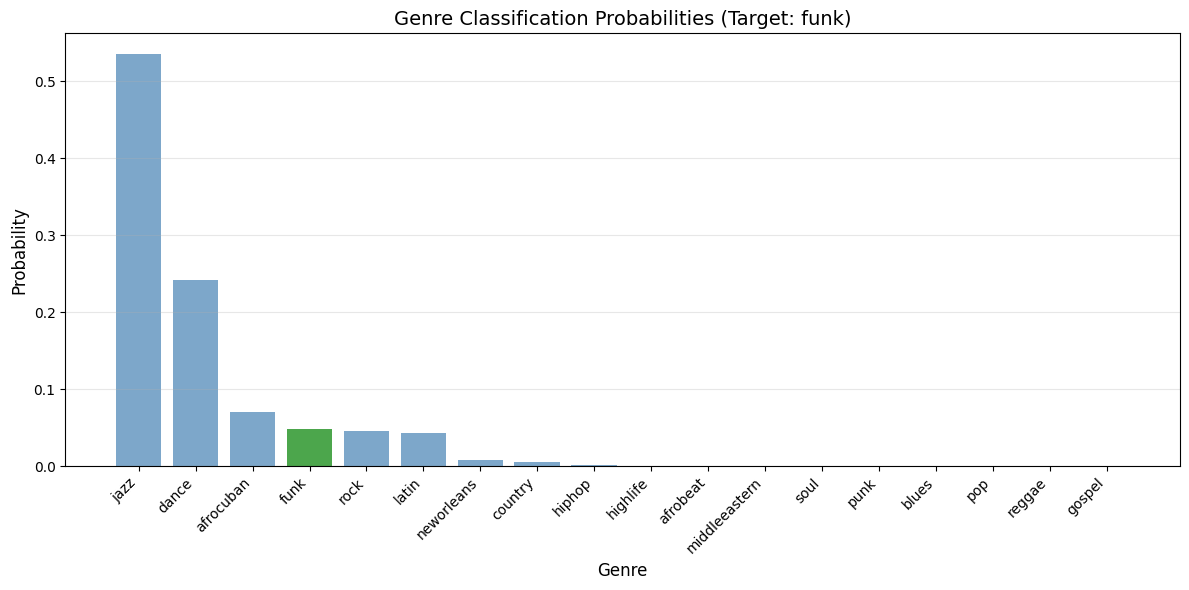

In [ ]:
def plot_genre_probabilities(all_probs, target_genre):
    """Plot bar chart of genre probabilities."""
    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}
    genre_names = [idx_to_genre.get(i, f"class_{i}") for i in range(len(all_probs))]

    # Sort by probability
    sorted_indices = np.argsort(all_probs)[::-1]
    sorted_probs = all_probs[sorted_indices]
    sorted_genres = [genre_names[i] for i in sorted_indices]

    # Highlight target genre
    colors = ['green' if g == target_genre else 'steelblue' for g in sorted_genres]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(sorted_probs)), sorted_probs, color=colors, alpha=0.7)
    plt.xlabel("Genre", fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.title(f"Genre Classification Probabilities (Target: {target_genre})", fontsize=14)
    plt.xticks(range(len(sorted_genres)), sorted_genres, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example: Generate one sample and visualize probabilities
genre = "funk"
bpm = 120
generated = generate_drum_loop(cvae, GENRE_TO_IDX[genre], bpm, num_samples=1)
generated = threshold_hits(generated, threshold=0.5)

pred_idx, confidence, all_probs = classify_generated_loop(cnn_classifier, generated[0])
plot_genre_probabilities(all_probs, genre)



DIAGNOSTIC: Analyzing Generated Samples for All Genres

       AFROBEAT:
  Accuracy: 0.0% (0/20)
  Most predicted as: neworleans (10 times)
  Avg confidence: 0.592

      AFROCUBAN:
  Accuracy: 0.0% (0/20)
  Most predicted as: jazz (14 times)
  Avg confidence: 0.620

          BLUES:
  Accuracy: 0.0% (0/20)
  Most predicted as: jazz (13 times)
  Avg confidence: 0.577

        COUNTRY:
  Accuracy: 5.0% (1/20)
  Most predicted as: jazz (13 times)
  Avg confidence: 0.559

          DANCE:
  Accuracy: 0.0% (0/20)
  Most predicted as: jazz (13 times)
  Avg confidence: 0.547

           FUNK:
  Accuracy: 0.0% (0/20)
  Most predicted as: jazz (14 times)
  Avg confidence: 0.555

         GOSPEL:
  Accuracy: 0.0% (0/20)
  Most predicted as: jazz (16 times)
  Avg confidence: 0.564

       HIGHLIFE:
  Accuracy: 0.0% (0/20)
  Most predicted as: jazz (14 times)
  Avg confidence: 0.564

         HIPHOP:
  Accuracy: 0.0% (0/20)
  Most predicted as: jazz (10 times)
  Avg confidence: 0.647

          

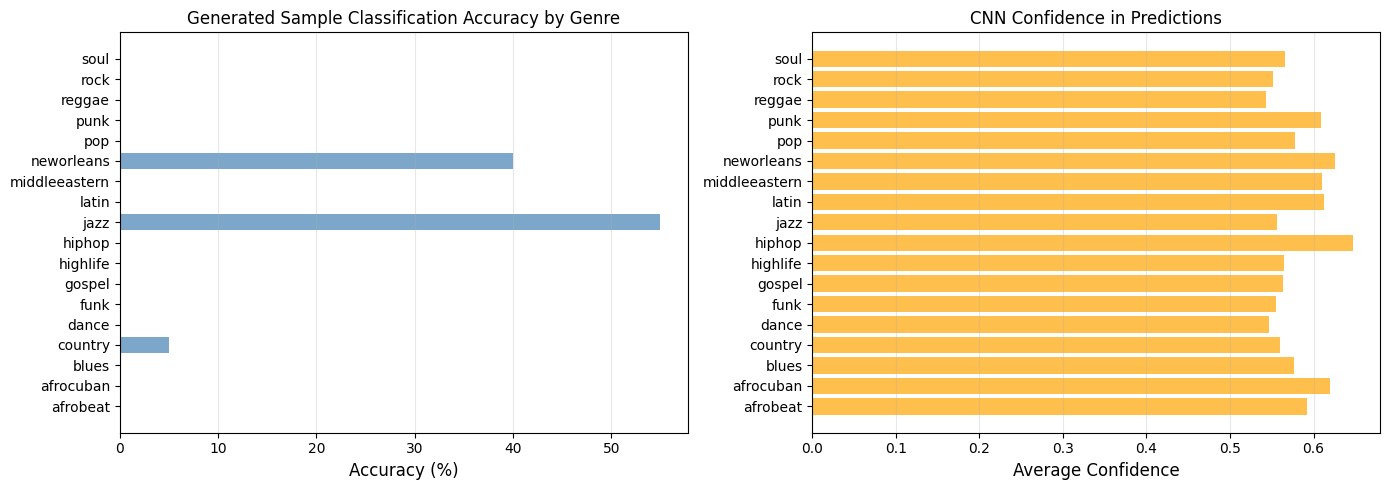

In [ ]:
diagnosis_results = diagnose_generated_samples(cvae, cnn_classifier, num_samples_per_genre=20)

## **ROC-AUC Analysis for CNN and SVM Classifiers**


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle


### **Collect Predictions from CNN Classifier**


In [ ]:
def collect_cnn_predictions(cnn_model, test_ds):
    """
    Collect all predictions and true labels from CNN classifier.

    Returns:
        y_true: True genre labels
        y_pred: Predicted genre labels (argmax)
        y_proba: Prediction probabilities for all classes
    """
    y_true_list = []
    y_proba_list = []

    print("Collecting CNN predictions...")
    for X_batch, y_batch in test_ds:
        # Get probability predictions
        proba = cnn_model.predict(X_batch, verbose=0)
        y_proba_list.append(proba)
        y_true_list.append(y_batch.numpy())

    y_true = np.concatenate(y_true_list, axis=0)
    y_proba = np.concatenate(y_proba_list, axis=0)
    y_pred = np.argmax(y_proba, axis=1)

    print(f"Collected {len(y_true)} samples")
    print(f"Probability shape: {y_proba.shape}")

    return y_true, y_pred, y_proba

y_true_cnn, y_pred_cnn, y_proba_cnn = collect_cnn_predictions(cnn_classifier, cnn_test_ds)

Collected 2033 samples
Probability shape: (2033, 18)


### **Collect Predictions from SVM Classifier**


In [ ]:
def collect_svm_predictions(encoder, svm_model, test_ds):
    """
    Collect all predictions from SVM classifier using latent space.

    Returns:
        y_true: True genre labels
        y_pred: Predicted genre labels
        y_decision: Decision function values (for ROC curves)
    """
    y_true_list = []
    y_decision_list = []

    print("Collecting SVM predictions...")
    for features in test_ds:
        X_batch, cond_batch = process_batch(features)
        y_true = features["style"]["primary"].numpy()

        # Get latent representations
        z_mean, _, _ = encoder([X_batch, cond_batch], training=False)
        z_mean_np = z_mean.numpy()

        # Get decision function values (for ROC)
        decision = svm_model.decision_function(z_mean_np)

        y_true_list.append(y_true)
        y_decision_list.append(decision)

    y_true = np.concatenate(y_true_list, axis=0)
    y_decision = np.concatenate(y_decision_list, axis=0)
    y_pred = svm_model.predict(encoder([X_batch, cond_batch], training=False)[0].numpy())

    print(f"Collected {len(y_true)} samples")
    print(f"Decision function shape: {y_decision.shape}")

    return y_true, y_pred, y_decision

y_true_svm, y_pred_svm, y_decision_svm = collect_svm_predictions(encoder, svm_clf, dataset_test)


Collected 2033 samples
Decision function shape: (2033, 17)


### **Plot ROC Curves for CNN Classifier**


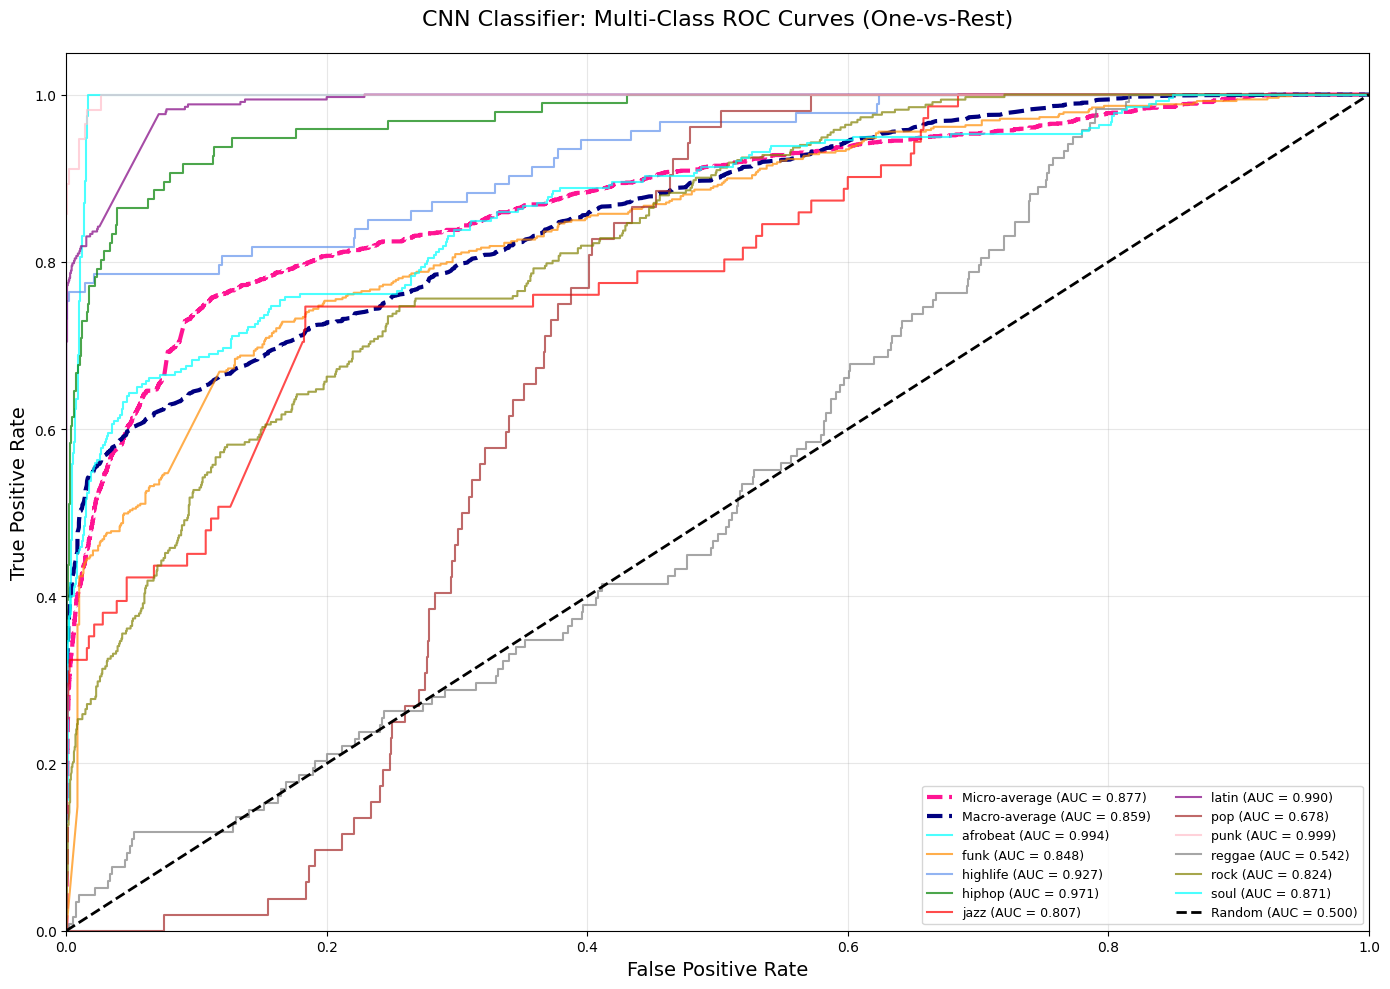


CNN CLASSIFIER ROC-AUC SUMMARY
Micro-average AUC: 0.8775
Macro-average AUC: 0.8594

Per-class AUC scores:
----------------------------------------------------------------------
       afrobeat: 0.9940
           funk: 0.8480
       highlife: 0.9267
         hiphop: 0.9710
           jazz: 0.8065
          latin: 0.9898
            pop: 0.6785
           punk: 0.9986
         reggae: 0.5422
           rock: 0.8245
           soul: 0.8705


In [ ]:
def plot_roc_curves_cnn(y_true, y_proba, save_path=None):
    """
    Plot ROC curves for CNN multi-class classification.
    """
    # Get unique classes present in y_true
    classes = np.unique(y_true)
    n_classes = len(classes)

    # Binarize the labels for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=classes)

    # Filter y_proba to only include columns for present classes
    y_proba_filtered = y_proba[:, classes]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    for i, cls in enumerate(classes):
        fpr[i] = dict()
        tpr[i] = dict()
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba_filtered[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_proba_filtered.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(14, 10))

    # Plot micro-average
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
             color='deeppink', linestyle='--', linewidth=3)

    # Plot macro-average
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
             color='navy', linestyle='--', linewidth=3)

    # Plot individual class curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                    'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
                    'magenta', 'yellow', 'black', 'blue', 'lime', 'teal', 'orange'])

    for i, color, cls in zip(range(n_classes), colors, classes):
        genre_name = idx_to_genre.get(cls, f"class_{cls}")
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5, alpha=0.7,
                label=f'{genre_name} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('CNN Classifier: Multi-Class ROC Curves (One-vs-Rest)', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=9, ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()

    # Print summary statistics
    print("\n" + "=" * 70)
    print("CNN CLASSIFIER ROC-AUC SUMMARY")
    print("=" * 70)
    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
    print("\nPer-class AUC scores:")
    print("-" * 70)

    for i, cls in enumerate(classes):
        genre_name = idx_to_genre.get(cls, f"class_{cls}")
        print(f"{genre_name:>15s}: {roc_auc[i]:.4f}")

    print("=" * 70)

    return fpr, tpr, roc_auc

fpr_cnn, tpr_cnn, roc_auc_cnn = plot_roc_curves_cnn(
    y_true_cnn,
    y_proba_cnn,
    save_path=os.path.join(OUTPUT_DIR, "cnn_roc_curves.png")
)

### **Plot ROC Curves for SVM Classifier**


SVM trained on 17 classes
Test set has 11 classes
Common classes: 11


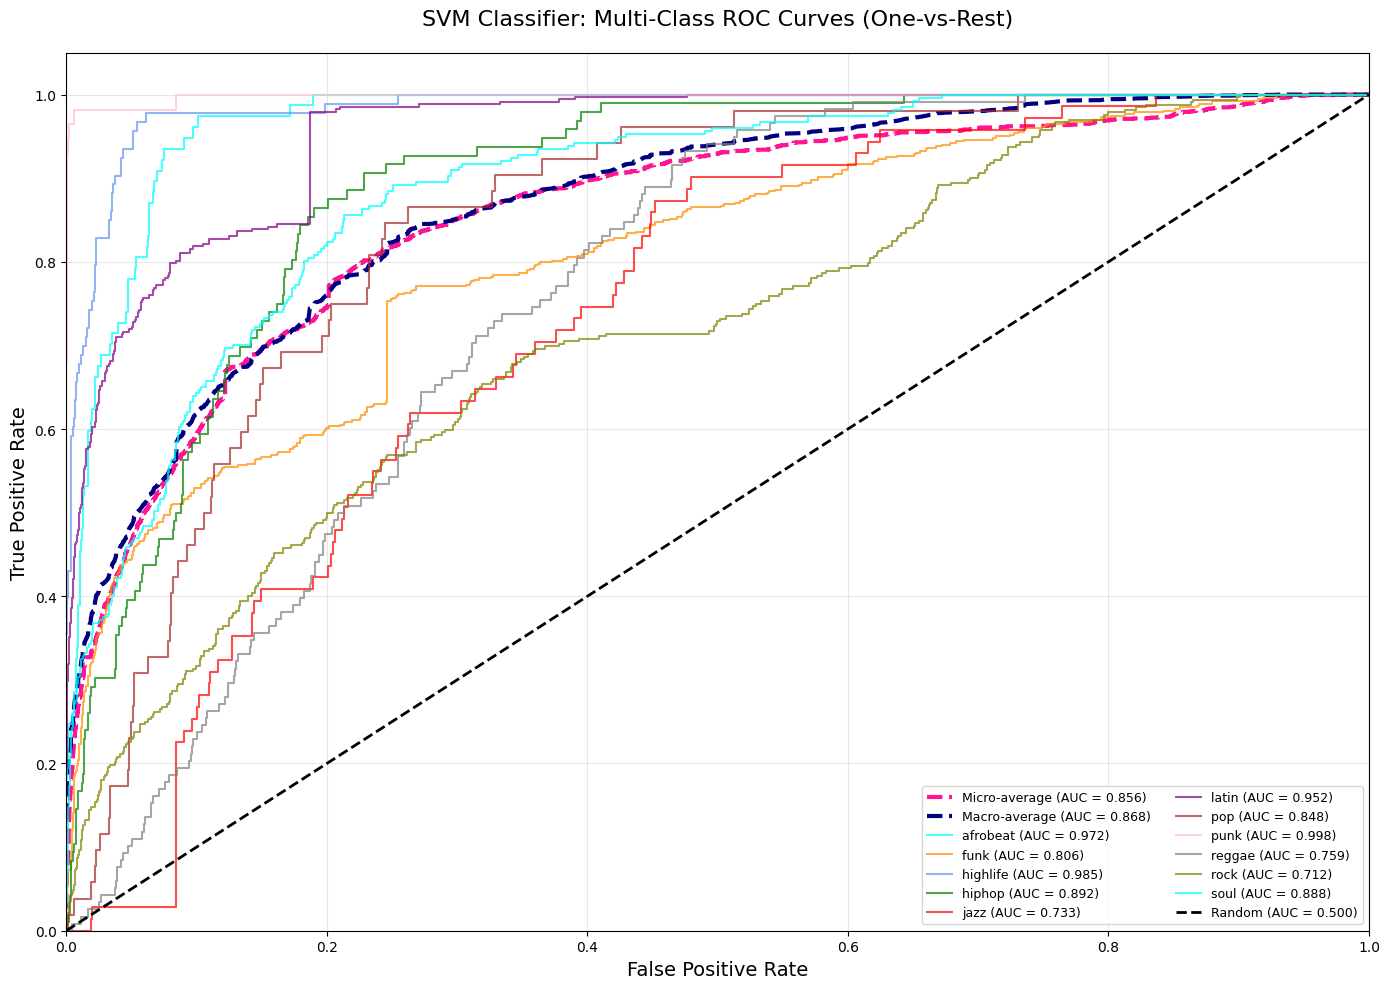


SVM CLASSIFIER ROC-AUC SUMMARY
Micro-average AUC: 0.8562
Macro-average AUC: 0.8681

Note: Showing only 11 classes that SVM was trained on

Per-class AUC scores:
----------------------------------------------------------------------
       afrobeat: 0.9718
           funk: 0.8062
       highlife: 0.9847
         hiphop: 0.8925
           jazz: 0.7331
          latin: 0.9518
            pop: 0.8485
           punk: 0.9982
         reggae: 0.7593
           rock: 0.7123
           soul: 0.8884


In [ ]:
def plot_roc_curves_svm(y_true, y_decision, svm_classes, save_path=None):
    """
    Plot ROC curves for SVM multi-class classification using decision function.

    Args:
        y_true: True labels
        y_decision: Decision function output from SVM
        svm_classes: Classes the SVM was trained on (from svm_model.classes_)
        save_path: Path to save plot
    """
    # Get unique classes present in test set
    test_classes = np.unique(y_true)

    # Find intersection of classes (only classes both trained and in test set)
    common_classes = np.intersect1d(svm_classes, test_classes)
    n_classes = len(common_classes)

    print(f"SVM trained on {len(svm_classes)} classes")
    print(f"Test set has {len(test_classes)} classes")
    print(f"Common classes: {len(common_classes)}")

    # Create mapping from common_classes to decision function indices
    class_to_decision_idx = {cls: np.where(svm_classes == cls)[0][0] for cls in common_classes}

    # Binarize the labels only for common classes
    y_true_bin = label_binarize(y_true, classes=common_classes)

    # Extract decision values only for common classes
    y_decision_filtered = np.zeros((y_decision.shape[0], n_classes))
    for i, cls in enumerate(common_classes):
        decision_idx = class_to_decision_idx[cls]
        y_decision_filtered[:, i] = y_decision[:, decision_idx]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    idx_to_genre = {v: k for k, v in GENRE_TO_IDX.items()}

    for i, cls in enumerate(common_classes):
        fpr[i] = dict()
        tpr[i] = dict()
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_decision_filtered[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_decision_filtered.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure(figsize=(14, 10))

    # Plot micro-average
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
             color='deeppink', linestyle='--', linewidth=3)

    # Plot macro-average
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
             color='navy', linestyle='--', linewidth=3)

    # Plot individual class curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                    'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
                    'magenta', 'yellow', 'black', 'blue', 'lime', 'teal', 'orange'])

    for i, color, cls in zip(range(n_classes), colors, common_classes):
        genre_name = idx_to_genre.get(cls, f"class_{cls}")
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5, alpha=0.7,
                label=f'{genre_name} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('SVM Classifier: Multi-Class ROC Curves (One-vs-Rest)', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=9, ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()

    # Print summary statistics
    print("\n" + "=" * 70)
    print("SVM CLASSIFIER ROC-AUC SUMMARY")
    print("=" * 70)
    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
    print(f"\nNote: Showing only {n_classes} classes that SVM was trained on")
    print("\nPer-class AUC scores:")
    print("-" * 70)

    for i, cls in enumerate(common_classes):
        genre_name = idx_to_genre.get(cls, f"class_{cls}")
        print(f"{genre_name:>15s}: {roc_auc[i]:.4f}")

    print("=" * 70)

    return fpr, tpr, roc_auc, common_classes

fpr_svm, tpr_svm, roc_auc_svm, svm_common_classes = plot_roc_curves_svm(
    y_true_svm,
    y_decision_svm,
    svm_clf.classes_,
    save_path=os.path.join(OUTPUT_DIR, "svm_roc_curves.png")
)
